In [1]:

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes

from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
#%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
%matplotlib widget

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


Clean Notebook for NGC253

Featuring:

HCO+ 4-3
HCN 4-3
H13CN 4-3

HCN_J1-0
HCO+_J1-0
H13CO+_J1-0_and_SiO_J2-1
H13CN_J1-0
CO_J3-2

CCH_N1-0
HC3NJ11-10

Part 1: Updates

Part 2: File Reads, Integrated Maps

Part 3: Image Ratios

Part 4: Channel Maps

Part 5: PV Plots

Part 6: Reporojection

Part 7: Spectra

Part 8: Dendograms

# Part 1: Updates

In [1]:

#!py -m pip uninstall astropy
#!py -m pip install git+https://github.com/astropy/astropy

'''


!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!py -m pip install reproject
!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git 
!py -m pip install pyspeckit
!py -m pip install regions
!py -m pip install astrodendro
!py -m pip  install wcsaxes 
!py -m pip  install ipympl
!py -m pip install dask
!py -m pip install radio_beam
!py -m pip install casa_formats_io
#try:
#    !pip install casa_formats_io --no-binary :all:
#except:
#    !pip install casa_formats_io --no-cache --no-binary :all:

!py -m pip  install spectral_cube 
!py -m pip  install typing 
!py -m pip install mypy
!py -m pip  install typing_extensions 
'''

S
^C


'\n\n\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git\n!py -m pip install reproject\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git \n!py -m pip install pyspeckit\n!py -m pip install regions\n!py -m pip install astrodendro\n!py -m pip  install wcsaxes \n!py -m pip  install ipympl\n!py -m pip install dask\n!py -m pip install radio_beam\n!py -m pip install casa_formats_io\n#try:\n#    !pip install casa_formats_io --no-binary :all:\n#except:\n#    !pip install casa_formats_io --no-cache --no-binary :all:\n\n!py -m pip  install spectral_cube \n!py -m pip  install typing \n!py -m pip install mypy\n!py -m pip  install typing_extensions \n'

In [93]:
#HCN 4-3


path = 'H8_continuum.pbcor.fits'

cube = SpectralCube.read(path) #Load the important axes
cheader = fits.getheader(path)  
w1 = WCS(cheader) 
w1 = w1.dropaxis(2)#Get rid of the different slices

cube.allow_huge_operations=True

# ex: c = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')


cen_p1 = SkyCoord('00h47m34.034s', '-25d17m29.68s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.234s', '-25d17m09.68s', frame='icrs')

scP = SpectralCube.read(path)
sc = scP.with_spectral_unit(u.km/u.s,velocity_convention="radio")
scW = sc.wcs[:][:][0]


raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]


subcube = sc[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube

subcube.allow_huge_operations=True
moment_0_sub  = subcube.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub   = subcube.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub  = subcube.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub = subcube.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 

sc2 = subcube.spectral_slab(-200. *u.km / u.s, 700. *u.km / u.s)  # Crop out velocities we don't care about 

sc2.allow_huge_operations=True
moment_0_sub2  = sc2.moment(order=0,how='slice')            # Calculate the Moment 0 map 
max_map_sub2   = sc2.apply_numpy_function(np.nanmax,axis=0) # Calculate the Maximum map 
moment_1_sub2  = sc2.moment(order=1,how='slice')            # Calculate the Moment 1 map 
sigma_map_sub2 = sc2.linewidth_sigma(how='slice')           # Calculate the velocity dispersion map 





#Find Noise 
Np1 = SkyCoord('00h47m34.3s', '-25d17m11s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m34.0s', '-25d17m10s', frame='icrs')
NraDP1 = [int(scW.world_to_pixel(Np1)[0]),int(scW.world_to_pixel(Np1)[1])]
NraDP2 = [int(scW.world_to_pixel(Np2)[0]),int(scW.world_to_pixel(Np2)[1])]
Nsc1 = sc[0:int(len(sc)/3),NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]].moment(order=0,how='slice') # Make a subcube away from the signals
#Find StandardDev of this noise cube
m1=Nsc1.std()/u.K/u.km*u.s

print(m1)



badpixS = pylab.where(abs(moment_0_sub.hdu.data)<m1*3)                 # Get ready to mask the data based on moment map

moment_1_sub.hdu.data[badpixS] = np.nan                          # Mask the moment 1 map
sigma_map_sub.hdu.data[badpixS] = np.nan                         # Mask the velocity dispersion map

scWCS = subcube.wcs[:][:][0]


########


fig1 = pylab.figure(1,figsize=(30,30))


######Moment 0 and Max map

ax3 = pylab.subplot(3,3,1,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im3 = pylab.imshow(moment_0_sub.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im3,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0 u',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax4 = pylab.subplot(3,3,2, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im4=pylab.imshow(max_map_sub.data,cmap='Greys',vmax=50,vmin=-5)
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im4,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission u',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax0 = pylab.subplot(3,3,5,projection=scWCS) 
RA = ax0.coords[0]                                                                  # 
Dec = ax0.coords[1]
im0 = pylab.imshow(moment_1_sub.hdu.data,cmap='Greys')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im0,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1 u',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax9 = pylab.subplot(3,3,6, projection=scWCS)
RA = ax9.coords[0]                                                                  # 
Dec = ax9.coords[1]
im9=pylab.imshow(sigma_map_sub.data,cmap='Greys')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax9.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im9,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='sig Emission u',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  



######Moment 0 and Max map

ax5 = pylab.subplot(3,3,3,projection=scWCS) 
RA = ax3.coords[0]                                                                  # 
Dec = ax3.coords[1]
im5 = pylab.imshow(moment_0_sub2.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im5,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 0',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax6 = pylab.subplot(3,3,4, projection=scWCS)
RA = ax4.coords[0]                                                                  # 
Dec = ax4.coords[1]
im6=pylab.imshow(max_map_sub2.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax4.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im6,fraction=0.046,pad=0.04)                                      
cb.set_label(label='Peak Emission (K)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='Peak Emission',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  

######Moment 0 and Max map

ax7 = pylab.subplot(3,3,7,projection=scWCS) 
RA = ax7.coords[0]                                                                  # 
Dec = ax7.coords[1]
im7 = pylab.imshow(moment_1_sub2.hdu.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im7,fraction=0.046,pad=0.04)                                     
cb.set_label(label='Integrated Flux Density Center(K km/s)',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s='Moment 1',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  


ax8 = pylab.subplot(3,3,8, projection=scWCS)
RA = ax8.coords[0]                                                                  # 
Dec = ax8.coords[1]
im8=pylab.imshow(sigma_map_sub2.data,cmap='rainbow')
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
y,x = [int(scWCS.world_to_pixel(center)[0]),int(scWCS.world_to_pixel(center)[1])]
pylab.plot(y,x,'+',ms=7,mec='black',mfc='black',mew=2,alpha=.5)
pylab.annotate("Center",(y,x+16))
RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=0) 
ax8.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(im8,fraction=0.046,pad=0.04)                                      
cb.set_label(label='sig km/s',fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)  
pylab.annotate(s='sig ',fontsize=20,xy=(0.02,0.91),xycoords="axes fraction")  

pylab.tight_layout(w_pad=10,h_pad=5)


ax3.set_title("NGC253.HCN_4-3.pbcor.fits")
ax4.set_title("NGC253.HCN_4-3.pbcor.fits")

fig1.savefig("pres_image")




IndexError: list index out of range

# Part 8: Dendograms

In [25]:
Names=[1,2,3,4,5,6,7,8,9,10,11,12]

#Bars = np.load("CZM_Beam_Area_Ratios.npy")
#NBars = np.load("NGC_Beam_Area_Ratios.npy")

#SpecRes = np.load("CZM_Sres.npy")
#NSpecRes = np.load("NGC_Sres.npy")

In [2]:

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX = [[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    print(metadata)
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=False
                    #stypes.append('trunk')
                else:
                    Cont = True 
                    #stypes.append('branch')

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #if((float((s.radius*np.pi/180*3.5/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*3.5/u.deg)))*10**6>.55):
            if((float((s.radius*np.pi/180*3.5/u.deg)))*10**6<18):

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 

                #print(sig_Sh,s.v_rms)
                


                #Require size greater than the beam and velocity greater than the spectral resolution
                #if(sig_Sh>metadata["velocity_scale"]*u.s/u.km and ((np.sqrt(nproj_pix/np.pi)))>np.sqrt(metadata['beam_area_ratio'])/u.pix and ((np.sqrt(nproj_pix*area_res/np.pi)))*10**6 <24):
                #Shetty Def:
                #if(sig_Sh>metadata["velocity_scale"]*u.s/u.km and ((np.sqrt(nproj_pix/np.pi)))>np.sqrt(metadata['beam_area_ratio'])/u.pix and ((np.sqrt(nproj_pix*area_res/np.pi)))*10**6 <24):
                #Astrodendro Def:
                #If I require the radius to be larger than the beam I miss the clusters with this definition ?
                #if(sig_Sh>metadata["velocity_scale"]*u.s/u.km and (s.radius*np.pi/180*3.5/u.deg)>np.sqrt(metadata['beam_area_ratio']*area_res)/u.pix and (s.radius*np.pi/180*3.5/u.deg)*10**6<24):
                #if(sig_Sh*(s.radius*3600/metadata['arc_per_pix_x']/u.deg*u.arcsec)**2>3*metadata["velocity_scale"]*u.s/u.km*1*u.pix**2 and (s.radius*np.pi/180*3.5/u.deg)*10**6<20):
                #if(sig_Sh*(s.radius*3600/metadata['arc_per_pix_x']/u.deg*u.arcsec)**2>3*(np.max(I[0])-np.min(I[0]))*metadata["velocity_scale"]*u.s/u.km*1*u.pix**2 and (s.radius*np.pi/180*3.5/u.deg)*10**6<20):
                #if(sig_Sh >.01):
                if(True):
                    #The flux from the continuum
                    #Convert to Jansky from Jansky per beam:
                    if(ColD ==True):
                        Cont_Flux=0

                        proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                        for lmi in range(len(proj)):

                            Cont_Flux+=ContData[proj[lmi]]
                        Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                        Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*3.5/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                    else:
                        Dust_Column=0
                    if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                        Dust_Column=0
                    lum = Flux_to_Lum(s.flux)

                    #Flux from the strcuture
                    s_flux = s.flux
                    #print(s_flux/Cont_Flux,s_flux,Cont_Flux)
                    #FR = s_flux/Cont_Flux

                    #Line_Mass=Flux_to_Mass(freq,s_flux)/u.Hz/u.mJy/u.s/u.solMass*u.erg
                    #Dust_Mass=Flux_to_Mass(freqC,Cont_Flux)#/u.Hz/u.mJy/u.s/u.solMass*u.erg
                    #Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/(np.sqrt(nproj_pix*(area_res)/np.pi)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg


                    #print(s_flux/Dust_Column)#,Line_Mass,Dust_Mass)

                    Index = tuple(I[i] for i in [0,1,2])
                    K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 

                    #Line_N = (Line_Mass/float(np.sqrt(nproj_pix*(area_res)/np.pi))/u.Mpc).to(u.kg)
                    if(t.is_leaf):
                        SizeA[2].append((float(np.sqrt(nproj_pix*(area_res)/np.pi)))) #define size as shetty does
                        SizeA[0].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                        #SigmaA[0].append((float(sig_Sh)))#
                        SigmaA[0].append((float(s.v_rms/u.km*u.s)))#
                        CDA[0].append(float(Dust_Column))
                        LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                        SIDS[0].append(float(t.idx))
                        MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                    if(t.is_branch	):
                        SizeA[3].append((float(np.sqrt(nproj_pix*(area_res)/np.pi)))) #define size as shetty does
                        SizeA[1].append((float((s.radius*np.pi/180*3.5/u.deg)))) #define size as astrodendro
                        #SigmaA[1].append((float(sig_Sh)))#
                        SigmaA[1].append((float(s.v_rms/u.km*u.s)))#
                        CDA[1].append(float(Dust_Column))
                        LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                        SIDS[1].append(float(t.idx))
                        MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
    SizeA[0] = np.array(SizeA[0])
    SizeA[1] = np.array(SizeA[1])
    SigmaA[0] = np.array(SigmaA[0])
    SigmaA[1] = np.array(SigmaA[1])
    CDA[0] = np.array(CDA[0])
    CDA[1] = np.array(CDA[1])
    LuminA[0] = np.array(LuminA[0])
    LuminA[1] = np.array(LuminA[1])
    SIDS[0] = np.array(SIDS[0])
    SIDS[1] = np.array(SIDS[1])
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0])
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1])
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    
    axA = np.empty((rows,columns),dtype = type(pylab.subplot(1,1,1,projection=WCS)))
    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    
    axA = np.empty((rows,columns),dtype = type(pylab.subplot(1,1,1,projection=WCS)))
    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun#Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(3.5*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L



#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    
Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

NameError: name 'Q' is not defined

HCOp-J4-3_Dend_Abs
Fixed_NGC253.HCO+_4-3_mJy_Reproject.pbcor.fits
402.5895690917969
(201, 469, 551) (201, 469, 551)
(201, 469, 499) (469, 551)
(201, 226, 135)


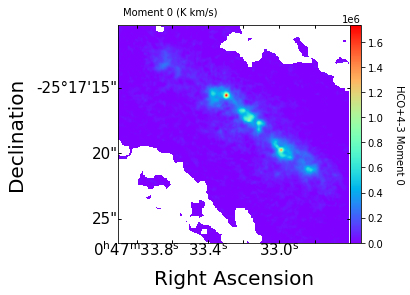

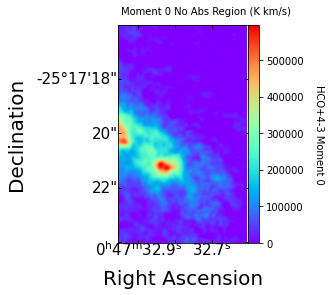

NameError: name 'Num_per_kg' is not defined

In [3]:
#HCO+ 4-3

Num=9
Overlaps=1#6
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "HCOp-J4-3_Dend_Abs"
name = "HCOp_j_4_3_CM_Abs.jpeg"
LineN = "HCO+4-3"


Names = np.load("Names.npy")
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC253.HCO+_4-3_mJy_Reproject.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]

pathCont = 'Continuum_Reproject.fits'#'Continuum_Reproject.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc

    
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc



#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

scF = Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)

#Do the same thing to the continuum image
scContW =  Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)

print(np.shape(datn),np.shape(scCont))
#Cubes with little dense gas and abs
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmU[0][0])
######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=.1*10**22/u.cm**2)

bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=.1*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))




fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)
#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)



    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]
CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
#xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6


radgpFORRATUL = RconUL[gp2]*10**6
siggpFORRATUL = SconUL[gp2]
lumFORRATUL = LuminConUL[gp2]
mom0FORRATUL = MOM0FLUXconUL[gp2]

CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])




gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3UL = np.where(lumFORRATUL>0)
lumFORRATUL = lumFORRATUL[gp3UL]
rgpFORRATUL = rgpUL[gp3UL]
mom0FORRATUL = mom0FORRATUL[gp3UL]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]

print(poptUL,pcovUL,"Size Linewidth Upper Left Region:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity Upper Left Region:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)

xpconhhUL = ax5.scatter(radgpFORRATUL,cgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures Upper Left",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure Region Upper Left",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
st2 = "UL, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratUL = axLam.scatter(lumFORRATUL/radgpFORRATUL**2,rgpFORRATUL,label="All_structure  Region of Interest",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

gp4UL=np.where(MOM0FLUXconUL>0)
mom0FORFluxUL=MOM0FLUXconUL[gp4UL]
radgpFORFluxUL=RconUL[gp4UL]*10**6
rgpFORFluxUL=SconUL[gp4UL]**2/RconUL[gp4UL]/10**6

gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
mom0_ratUL = axDelta.scatter(mom0FORFluxUL/radgpFORFluxUL**2,rgpFORFluxUL,label="All_structure  UL",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



In [ ]:
#HCN 4-3


Num = 10
Overlaps=1#4
Ram_Limiter = 1
Name = "HCN4-3_Abs"
name = "HCN4_3_CM_Contours_DS_10_Abs.jpeg"
LineN = "HCN4-3"



Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]

pathCont = 'Continuum_Reproject.fits'#'Continuum_Reproject.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc

    
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc



#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

scF = Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)

#Do the same thing to the continuum image
scContW =  Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)

print(np.shape(datn),np.shape(scCont))
#Cubes with little dense gas and abs
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmU[0][0])
######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=.1*10**22/u.cm**2)

bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=.1*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))




fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)
#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)



    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]
CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
#xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6


radgpFORRATUL = RconUL[gp2]*10**6
siggpFORRATUL = SconUL[gp2]
lumFORRATUL = LuminConUL[gp2]
mom0FORRATUL = MOM0FLUXconUL[gp2]

CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])




gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3UL = np.where(lumFORRATUL>0)
lumFORRATUL = lumFORRATUL[gp3UL]
rgpFORRATUL = rgpUL[gp3UL]
mom0FORRATUL = mom0FORRATUL[gp3UL]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]

print(poptUL,pcovUL,"Size Linewidth Upper Left Region:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity Upper Left Region:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)

xpconhhUL = ax5.scatter(radgpFORRATUL,cgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures Upper Left",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure Region Upper Left",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
st2 = "UL, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratUL = axLam.scatter(lumFORRATUL/radgpFORRATUL**2,rgpFORRATUL,label="All_structure  Region of Interest",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

gp4UL=np.where(MOM0FLUXconUL>0)
mom0FORFluxUL=MOM0FLUXconUL[gp4UL]
radgpFORFluxUL=RconUL[gp4UL]*10**6
rgpFORFluxUL=SconUL[gp4UL]**2/RconUL[gp4UL]/10**6

gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
mom0_ratUL = axDelta.scatter(mom0FORFluxUL/radgpFORFluxUL**2,rgpFORFluxUL,label="All_structure  UL",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



In [ ]:
#H13CN 4-3


Num = 8
Overlaps=1#5
Ram_Limiter = 1
Name = "H13CN4_3_Abs"
name = "H13CN4_3_CM_Contours_DS_10_Abs.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
RNames=np.load('RNames.npy')
SNames=np.load('SNames.npy')

RNames[Num] = NameR
SNames[Num] = NameS
print(RNames,SNames,NameR,NameS)
np.save("RNames",RNames)
np.save("SNames",SNames)

print(NameS)
paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]
print(path)
Confidences = np.load('Confidence_data.npy')
H13CN_MASK = np.load('H13CN_MASK_NGC.npy')
Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
#BP = np.where(Confidences<Overlaps)#Overlaps)
BP = np.where(H13CN_MASK<1) #Mask where HCN is not found >1 sigma
del Confidences
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths
#make metadata for the dendrogram
header = fits.getheader(path)
metadata = {}

metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*1,min_npix=15) #The main culprit




##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)
        if(s.v_rms>1*u.pix and s.radius>1*u.pix and  s.radius<24*2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)

pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix
radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t,metadata=metadata)
        
    if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>4.8*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2):
        
        
        
        
        
        
        
        if(t.is_leaf):
            radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
            sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
        if(t.is_branch	):
            radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
            sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
try:     
    popt, pcov = curve_fit(func, radsL*10**6, sigmasL) 
except:     
    popt, pcov = np.nan,np.nan
poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)

Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)

try:
    print(popt,pcov,"leaves:")
    print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
    print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
    print(poptB,pcovB,"branches:")
    print("a = ",poptB[0],"+-",np.sqrt(pcovB[0][0]))
    print("b = ",poptB[1],"+-",np.sqrt(pcovB[1][1]))
    print(poptCon,pcovCon,"All_structures:")
    print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
    print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

    fig = plt.figure()
    ax = pylab.subplot(2, 1, 1)
    xpL,xpB = ax.scatter(radsL*10**6,sigmasL),ax.scatter(radsB*10**6,sigmasB)
    xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
    ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])
    xpa1,xpa2,xpaTot = ax.plot(xs,ysL),ax.plot(xs,ysB),ax.plot(xs,ysCon)
    plt.xlabel("Size (pc)")
    plt.ylabel("Sigma (km/s)")
    pylab.show()
    ax2 = pylab.subplot(2, 1, 2)
    xpL,xpB = ax2.scatter(radsL*10**6,sigmasL),ax2.scatter(radsB*10**6,sigmasB)
    p,p2,p3 = ax2.plot(xs,ysL),ax2.plot(xs,ysB),ax2.plot(xs,ysCon)
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    plt.xlabel("Size (pc)")
    plt.ylabel("Sigma (km/s)")
    pylab.show()

except:
    
    print("Not Enough Well-Defined Structures")
NameSL = (NameS+"_Leaves")
NameSB = (NameS+"_Branches")
NameRL = (NameR+"_Leaves")
NameRB = (NameR+"_Branches")

np.save(NameSL,sigmasL)
np.save(NameSB,sigmasB)
np.save(NameRL,radsL)
np.save(NameRB,radsB)

H13COp_1_0_Abs
Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits
0.0001171929
(212, 400, 488) (212, 400, 488)
(212, 332, 353) (400, 488)
(212, 160, 95)


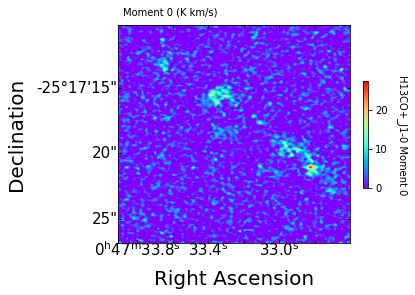

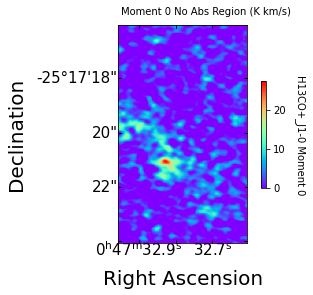

nan
JJ nan 1 / cm2


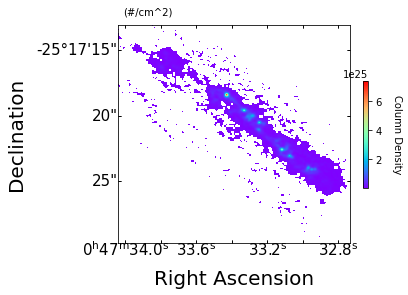

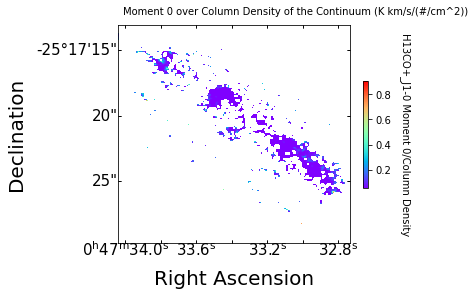

-0.21192041525768499
[50] [73] (120, 81)
<class 'float'> <class 'float'> 0.6083333333333333


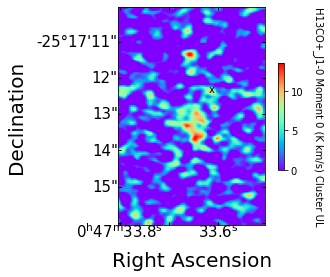

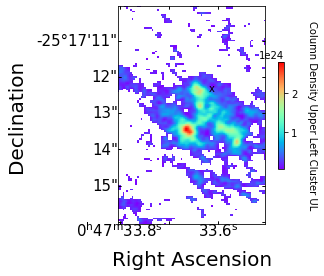

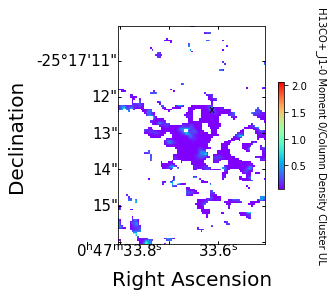

0.00010387950248654169

1 86754288000.0 Hz 0.0034556500308088518 m
7.198231852599878e-13 <class 'float'>
0.20722991228103602 arcsec 0.28256428241730003 arcsec
26.539583633028307 pix2
0.0001171929
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 8.37880858 pix2>, 'wavelength': <Quantity 0.00345565 m>, 'data_unit': Unit("Jy / beam"), 'arc_per_pix_y': <Quantity 0.05 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.05 arcsec / pix>, 'beam_major': <Quantity 0.28256428 arcsec>, 'beam_minor': <Quantity 0.20722991 arcsec>, 'beam_area_ratio': <Quantity 26.53958363 pix2>, 'spatial_scale': <Quantity 1.38888889e-05 deg>, 'velocity_scale': <Quantity 2.50166866 km / s>, 'vaxis': 0}
(76,) (23,)
0.022188376635313034
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 8.37880858 pix2>, 'wavelength': <Quantity 0.00345565 m>, 'data_unit': Unit("Jy / beam"), 'arc_per_pix_y': <Quantity 0.05 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.05 arcsec / pix>, 'beam_major': <Quantity 0.28256428 

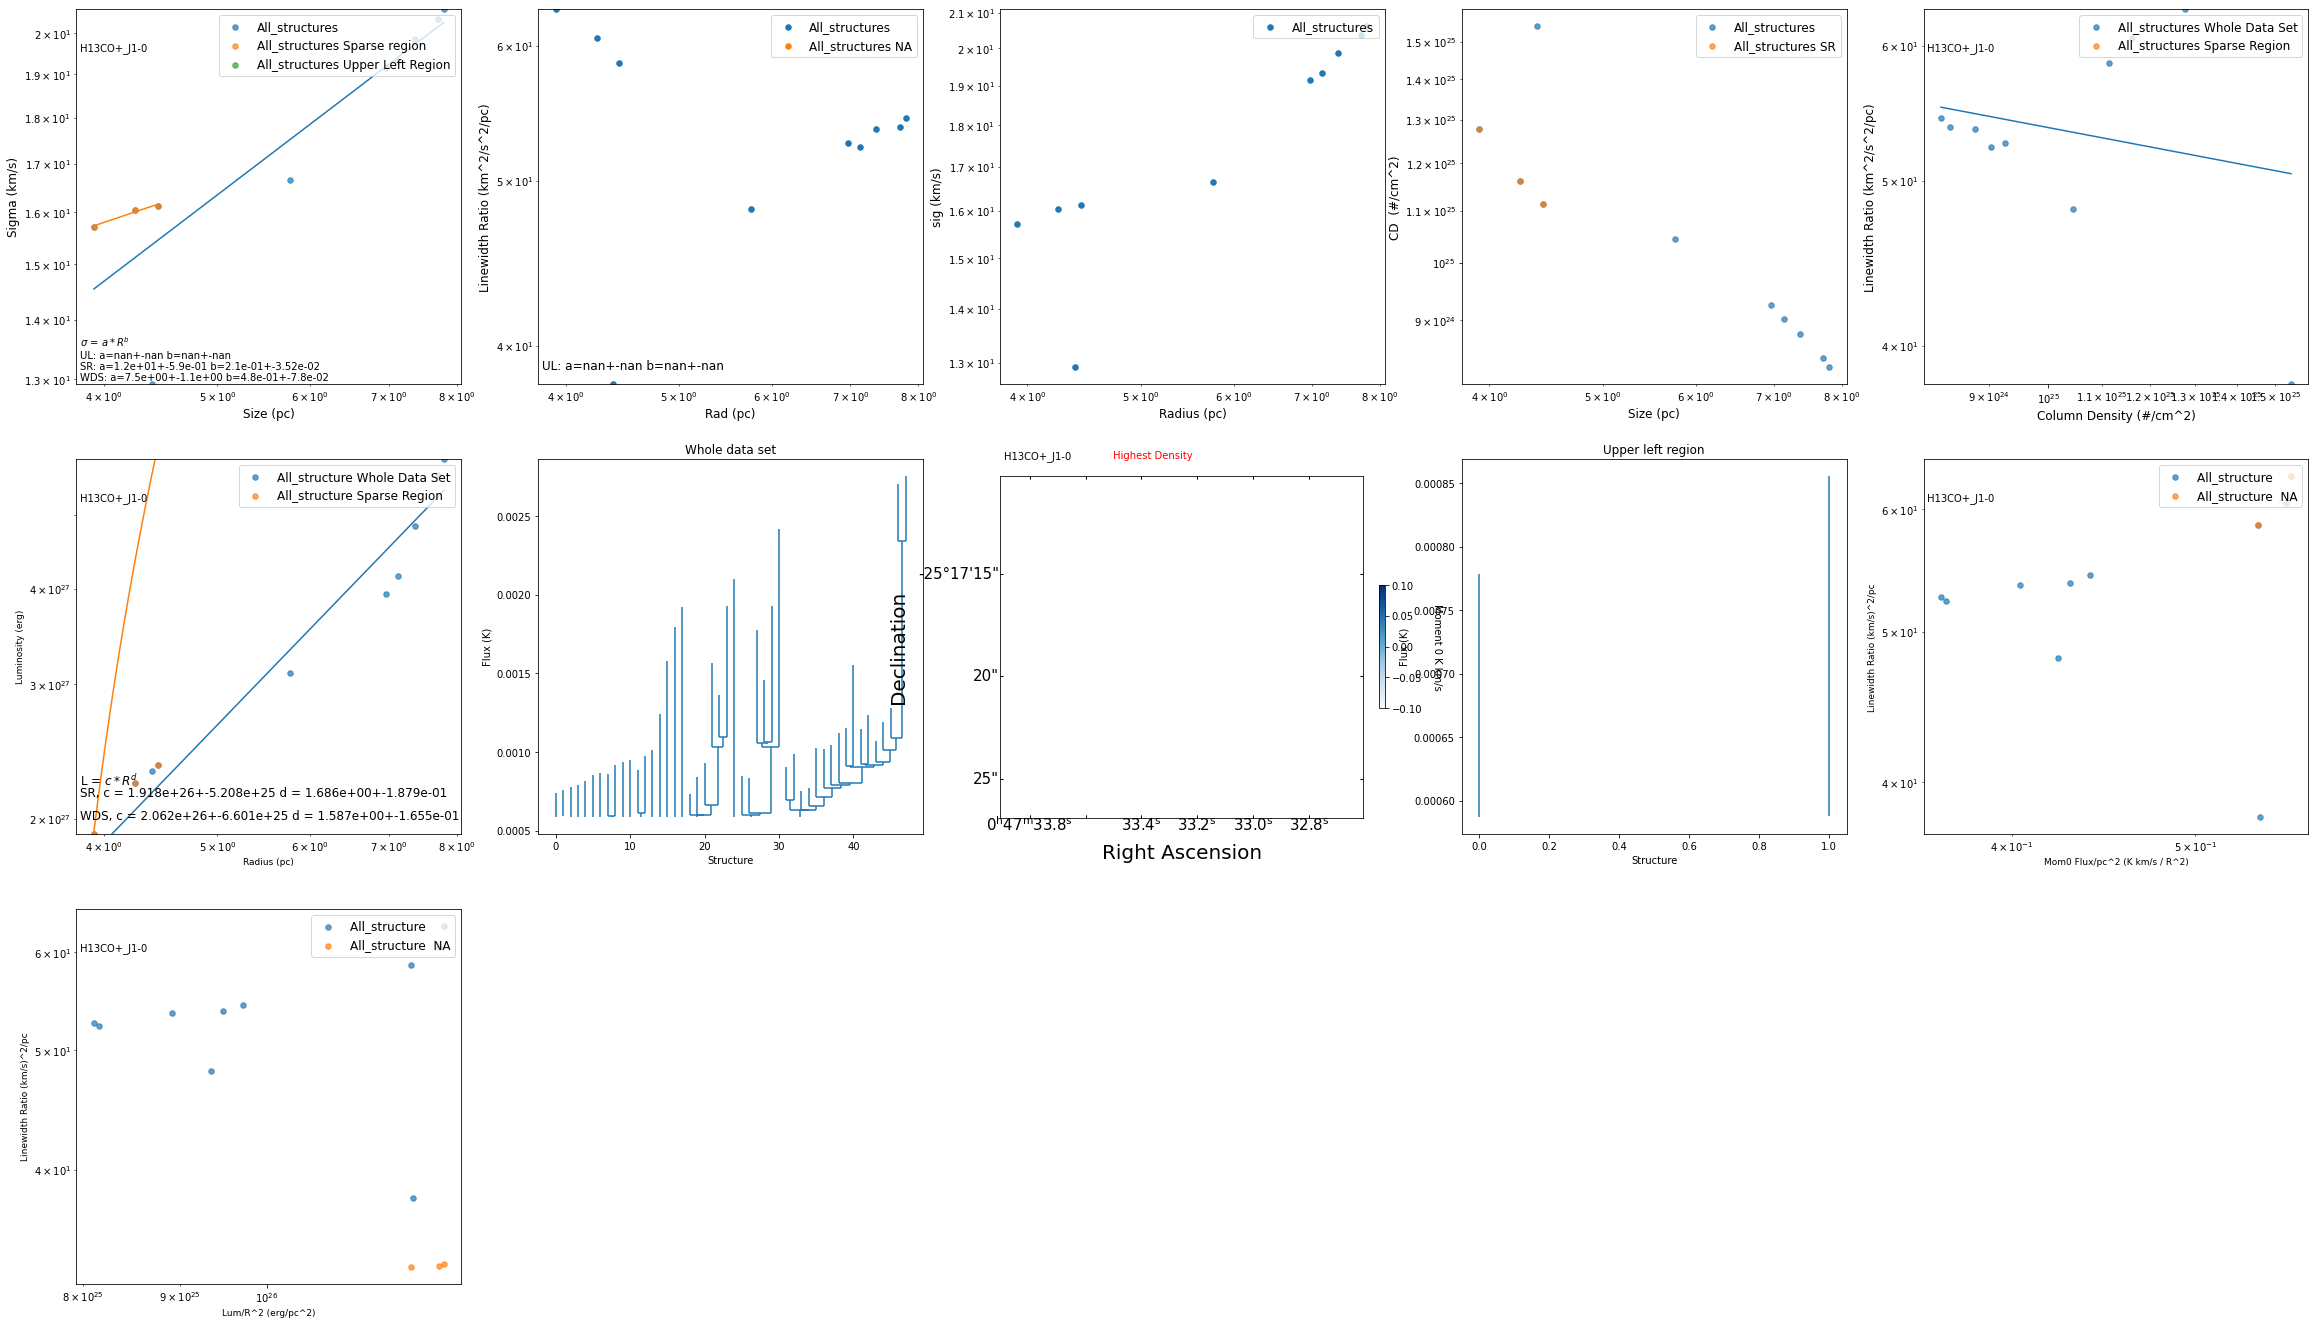

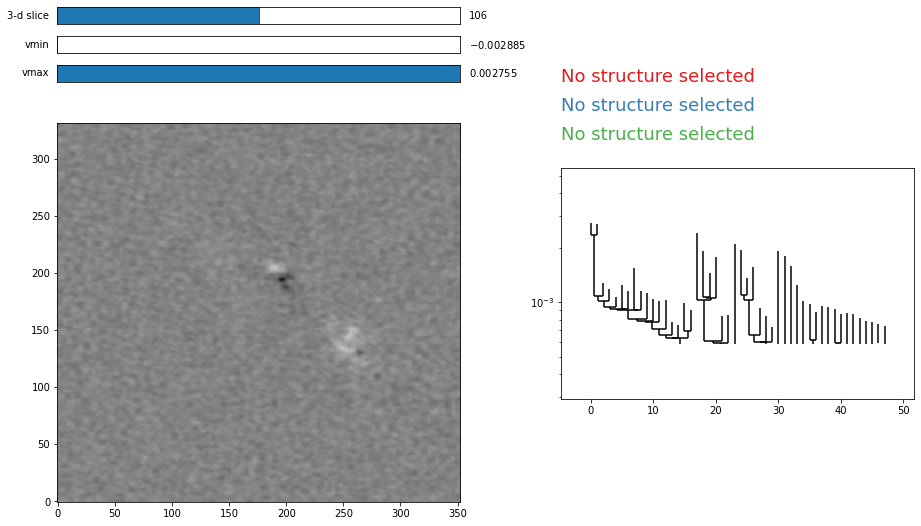

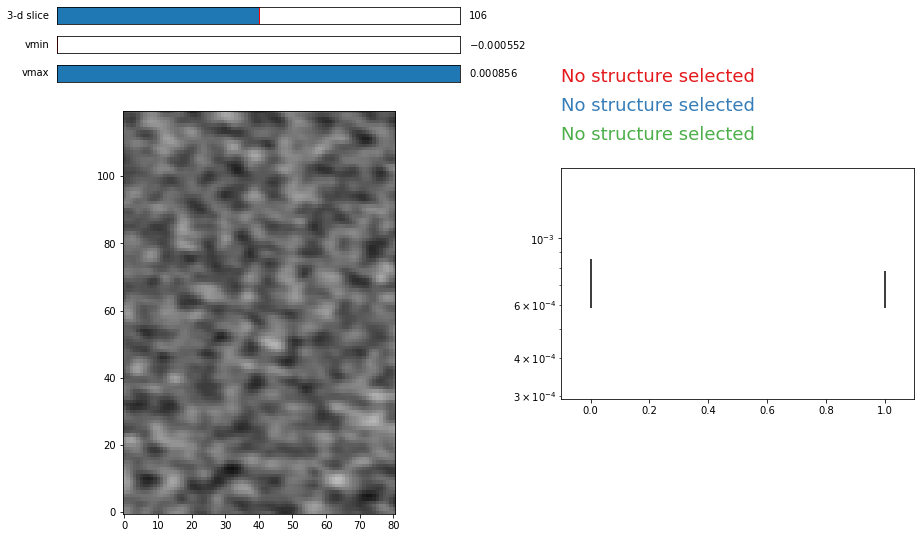

In [39]:
#H13CO 1-0


Num = 5
Overlaps=0#5
Ram_Limiter = 1
LineN="H13CO+_J1-0"
Name = "H13COp_1_0_Abs"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

Names = np.load("Names.npy")
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]

pathCont = 'Continuum_Reproject.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc

    
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc



#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp.spectral_slab(-50. *u.km / u.s, 500. *u.km / u.s)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

scF = Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)

#Do the same thing to the continuum image
scContW =  Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)

print(np.shape(datn),np.shape(scCont))
#Cubes with little dense gas and abs
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmU[0][0])
######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=7*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))



area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))




fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)
#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)




RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))
try:
    poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)
except:
    poptUL, pcovUL = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]
CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
try:
    xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
except:
    xsUL=np.nan
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
#xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






#Radius Luminosity fit

#xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
#ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])




gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)



#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6


gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



HCOp-J1_Dendrogram
Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits
0.0001405415854375365
(201, 281, 331) (201, 281, 331)
(201, 281, 299) (281, 331)
(201, 135, 81)


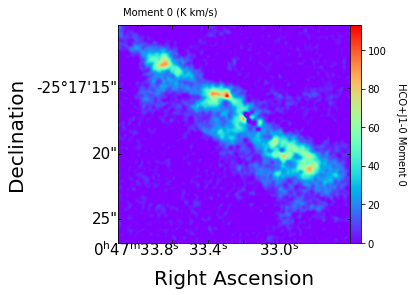

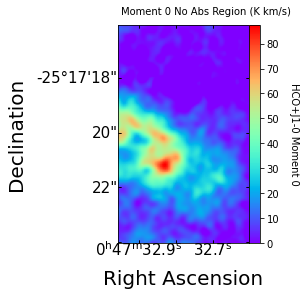

inf
JJ nan 1 / cm2


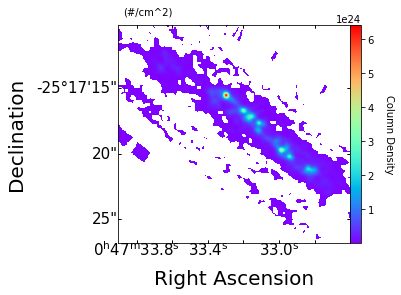

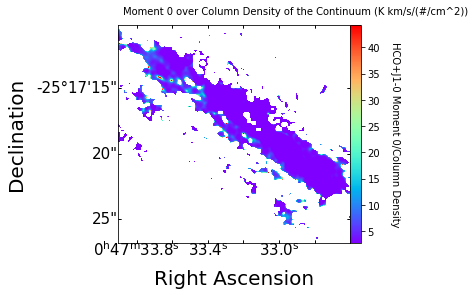

38.35286879385959
[27] [14] (34, 46)
<class 'float'> <class 'float'> 0.4117647058823529


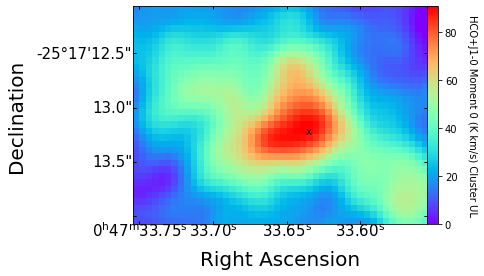

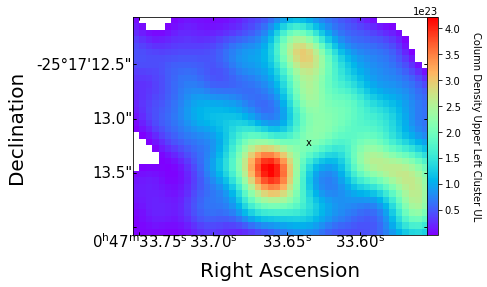

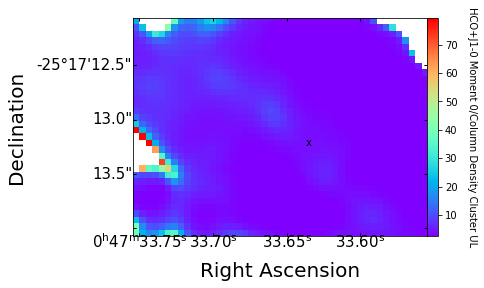

0.004125301648132525

1 89188523000.0 Hz 0.003361334484707186 m
9.999999999999364e-13 <class 'float'>
0.29466400892442335 arcsec 0.29466400892442335 arcsec
28.32725000000179 pix2


KeyboardInterrupt: 

In [61]:
#HCO+_J1-0

Num=0
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "HCOp-J1_Dendrogram"
LineN="HCO+J1-0"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2



Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]

pathCont = 'Continuum_Reproject_5pc_beam.fits'#'Continuum_Reproject.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc

    
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc



#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

scF = Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)

#Do the same thing to the continuum image
scContW =  Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)

print(np.shape(datn),np.shape(scCont))
#Cubes with little dense gas and abs
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmU[0][0])
######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=.1*10**22/u.cm**2)

bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=.1*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))




fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)
#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)



    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]
CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
#xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6


radgpFORRATUL = RconUL[gp2]*10**6
siggpFORRATUL = SconUL[gp2]
lumFORRATUL = LuminConUL[gp2]
mom0FORRATUL = MOM0FLUXconUL[gp2]

CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])




gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3UL = np.where(lumFORRATUL>0)
lumFORRATUL = lumFORRATUL[gp3UL]
rgpFORRATUL = rgpUL[gp3UL]
mom0FORRATUL = mom0FORRATUL[gp3UL]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]

print(poptUL,pcovUL,"Size Linewidth Upper Left Region:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity Upper Left Region:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)

xpconhhUL = ax5.scatter(radgpFORRATUL,cgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures Upper Left",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure Region Upper Left",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
st2 = "UL, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratUL = axLam.scatter(lumFORRATUL/radgpFORRATUL**2,rgpFORRATUL,label="All_structure  Region of Interest",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

gp4UL=np.where(MOM0FLUXconUL>0)
mom0FORFluxUL=MOM0FLUXconUL[gp4UL]
radgpFORFluxUL=RconUL[gp4UL]*10**6
rgpFORFluxUL=SconUL[gp4UL]**2/RconUL[gp4UL]/10**6

gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
mom0_ratUL = axDelta.scatter(mom0FORFluxUL/radgpFORFluxUL**2,rgpFORFluxUL,label="All_structure  UL",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



H13CN-J1_Abs
Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits
0.00014856743
(212, 400, 488) (212, 400, 488)
(212, 332, 353) (400, 488)
(212, 160, 95)


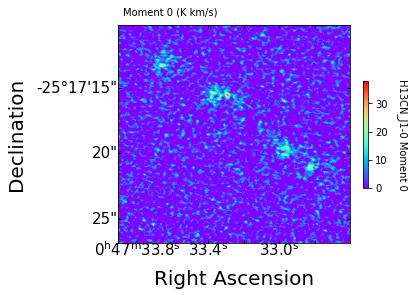

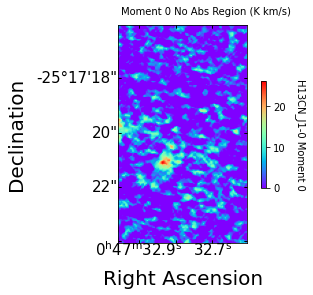

nan
JJ nan 1 / cm2


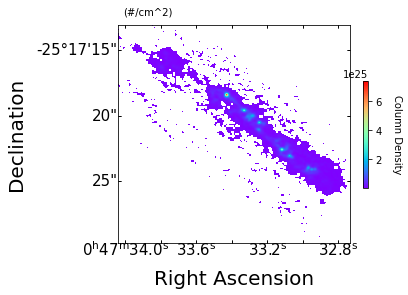

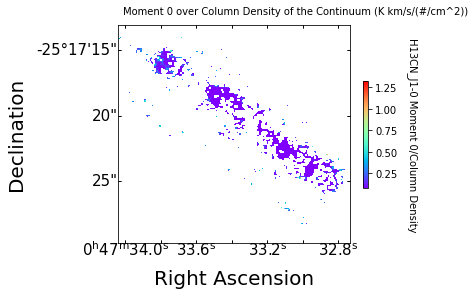

-0.004103967009035239
[37] [54] (120, 81)
<class 'float'> <class 'float'> 0.45


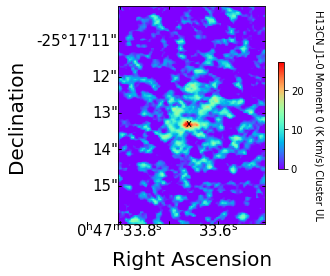

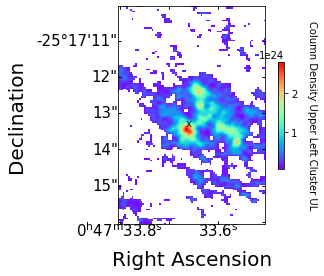

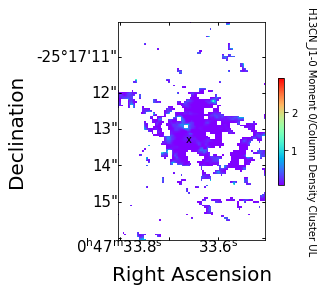

0.00013355070041821656

1 86338767000.0 Hz 0.0034722809743159755 m
7.198231852599878e-13 <class 'float'>
0.193741553900124 arcsec 0.2583761863464 arcsec
22.688180072694493 pix2
0.00014856743
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 8.37880858 pix2>, 'wavelength': <Quantity 0.00347228 m>, 'data_unit': Unit("Jy / beam"), 'arc_per_pix_y': <Quantity 0.05 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.05 arcsec / pix>, 'beam_major': <Quantity 0.25837619 arcsec>, 'beam_minor': <Quantity 0.19374155 arcsec>, 'beam_area_ratio': <Quantity 22.68818007 pix2>, 'spatial_scale': <Quantity 1.38888889e-05 deg>, 'velocity_scale': <Quantity 2.50166866 km / s>, 'vaxis': 0}
(70,) (12,)
0.027427004650235176
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 8.37880858 pix2>, 'wavelength': <Quantity 0.00347228 m>, 'data_unit': Unit("Jy / beam"), 'arc_per_pix_y': <Quantity 0.05 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.05 arcsec / pix>, 'beam_major': <Quantity 0.25837619 arcse

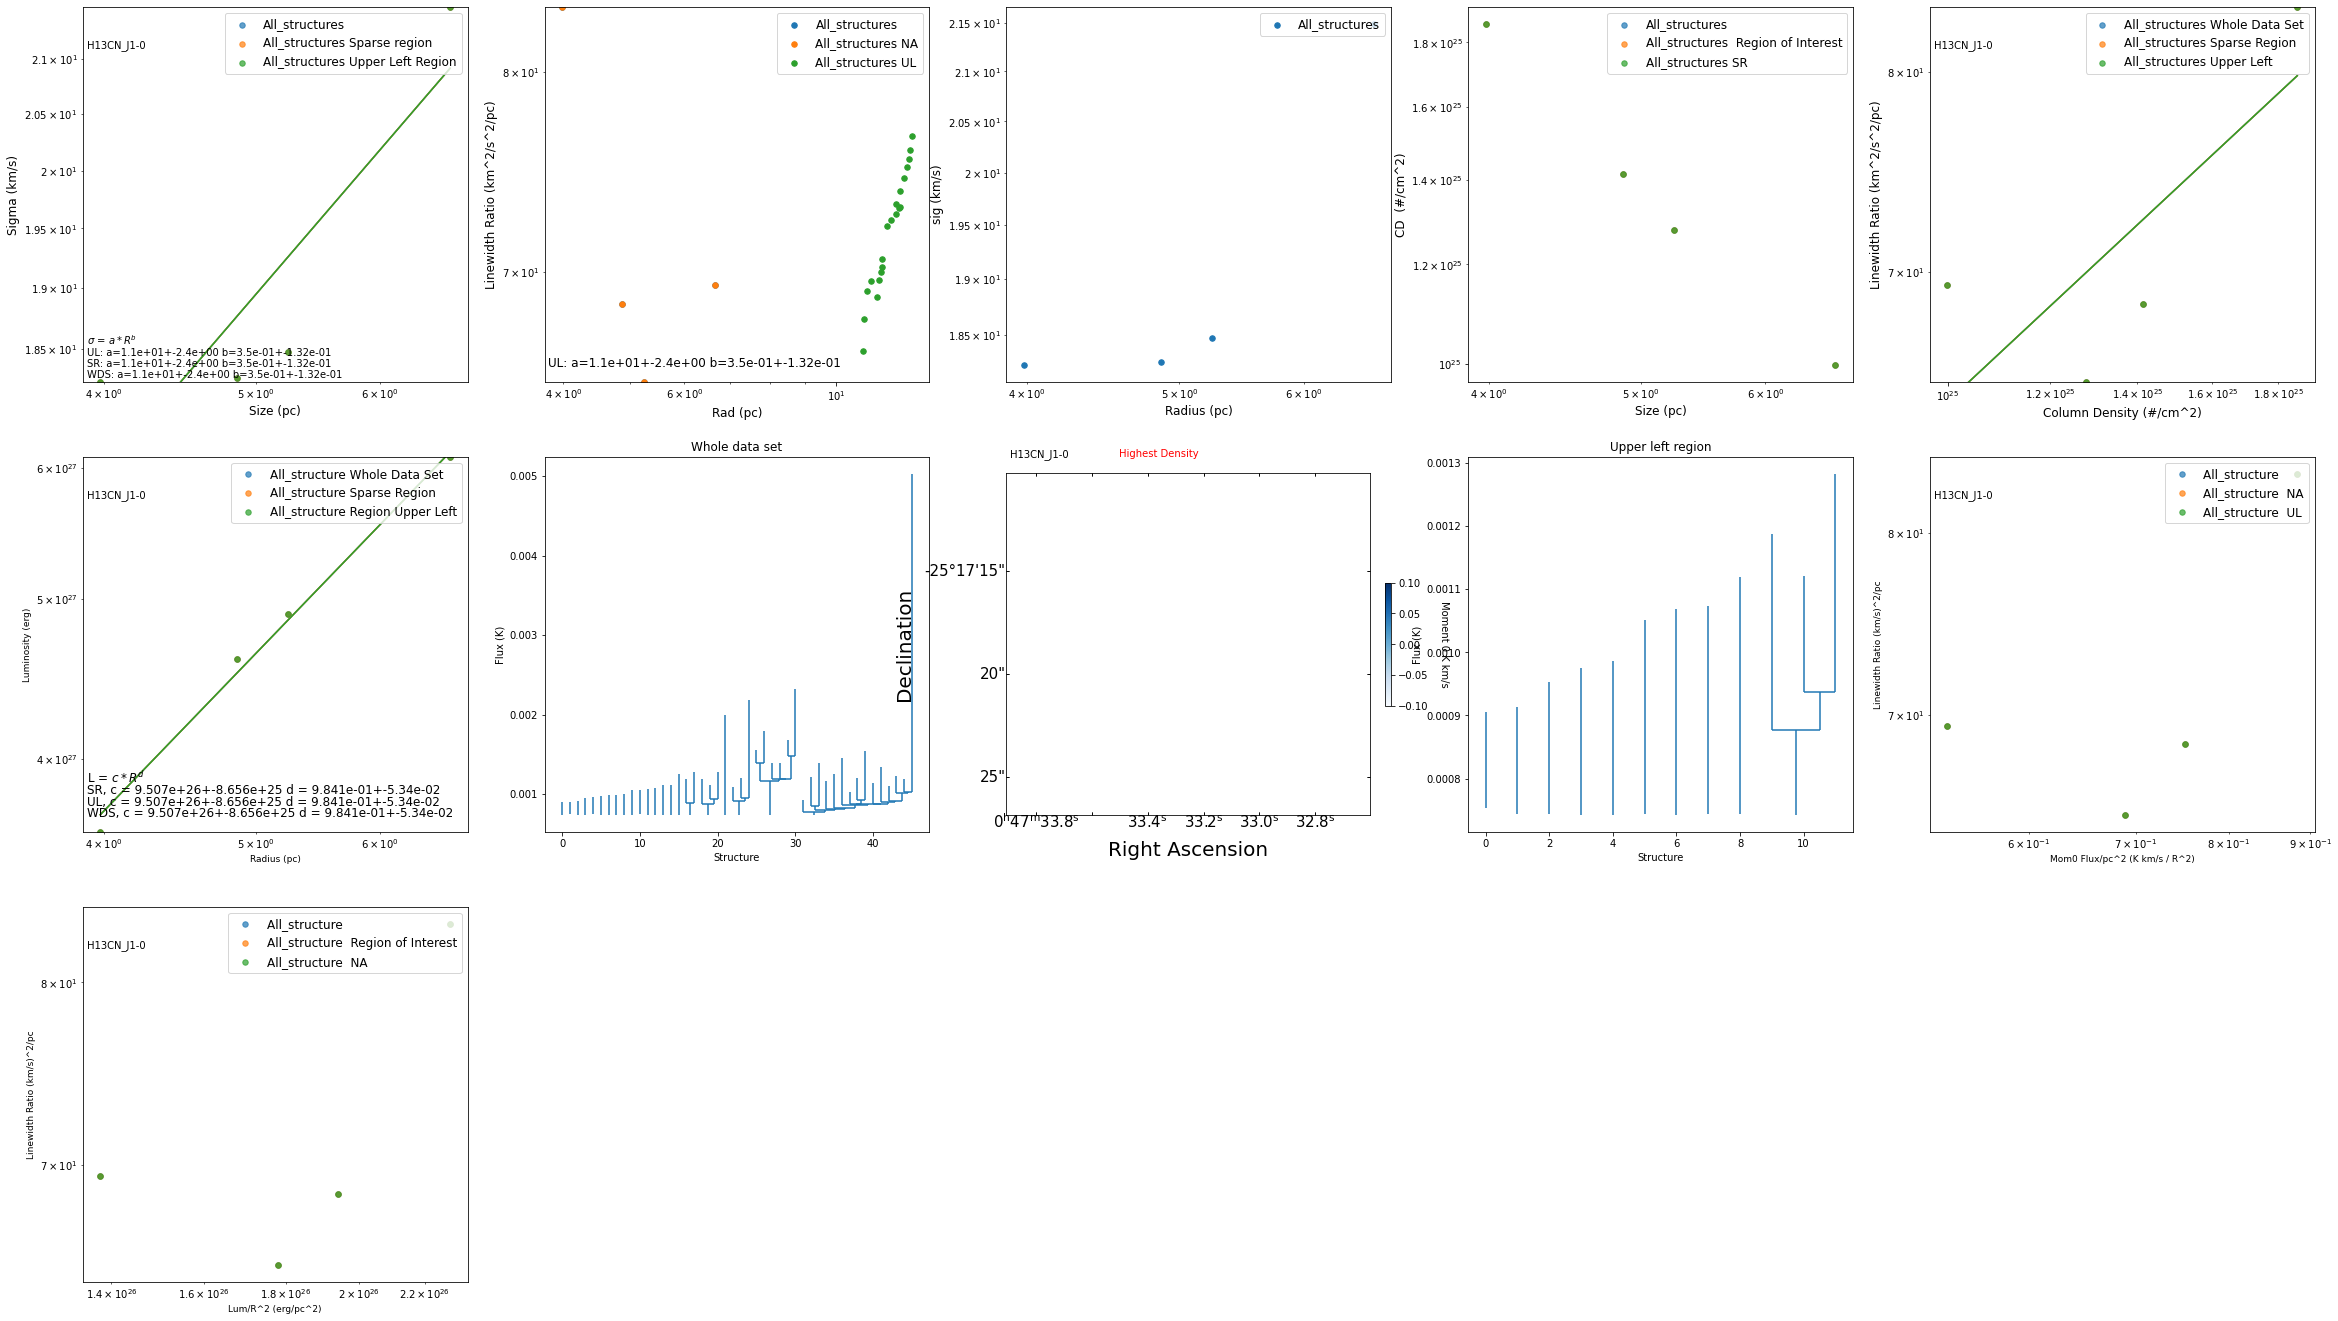

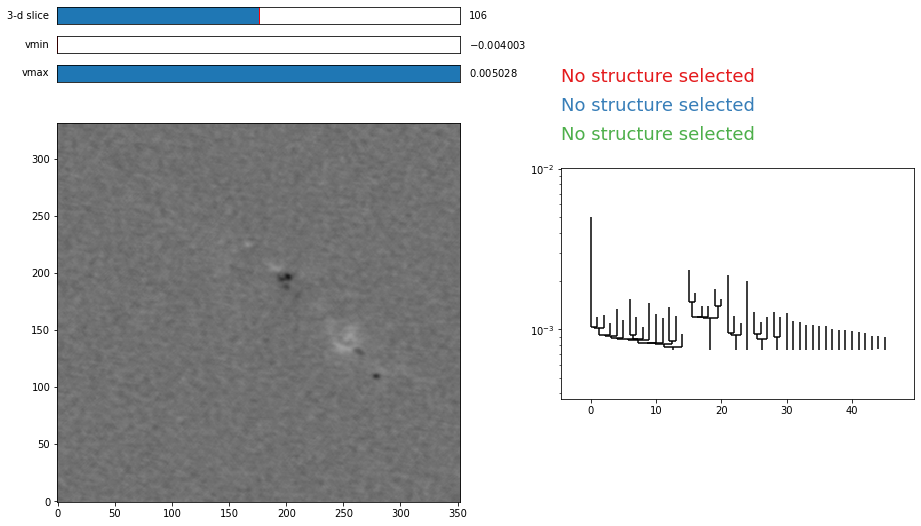

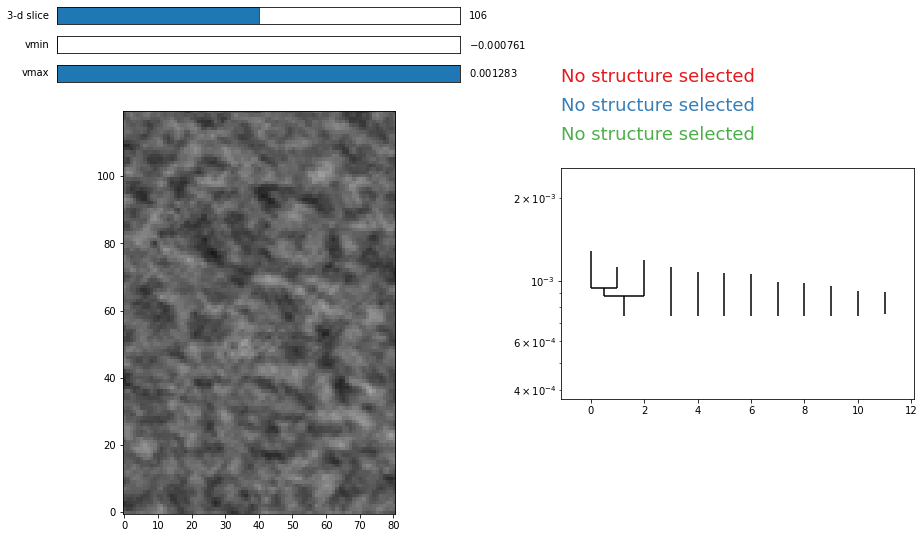

In [36]:
##### H13CN_J1-0

Num=2
Overlaps=0#4
LineN= "H13CN_J1-0"
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "H13CN-J1_Abs"
name ="H13CN_J1_0_Countours_CM_Abs.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2


Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]

pathCont = 'Continuum_Reproject.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc

    
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc



#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp.spectral_slab(-50. *u.km / u.s, 500. *u.km / u.s)

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

scF = Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)

#Do the same thing to the continuum image
scContW =  Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)

print(np.shape(datn),np.shape(scCont))
#Cubes with little dense gas and abs
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmU[0][0])
######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=7*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))




fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)#Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)#Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)


#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
print(RadsNA,RconNA)
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
try:
    poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)
except:
    poptConNA, pcovConNA =[np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]



    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))



try:
    poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)
except:
    poptUL, pcovUL  =[np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]




xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]
CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6


radgpFORRATUL = RconUL[gp2]*10**6
siggpFORRATUL = SconUL[gp2]
lumFORRATUL = LuminConUL[gp2]
mom0FORRATUL = MOM0FLUXconUL[gp2]

CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])




gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3UL = np.where(lumFORRATUL>0)
lumFORRATUL = lumFORRATUL[gp3UL]
rgpFORRATUL = rgpUL[gp3UL]
mom0FORRATUL = mom0FORRATUL[gp3UL]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]

print(poptUL,pcovUL,"Size Linewidth Upper Left Region:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity Upper Left Region:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)

xpconhhUL = ax5.scatter(radgpFORRATUL,cgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures Upper Left",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure Region Upper Left",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
st2 = "UL, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratUL = axLam.scatter(lumFORRATUL/radgpFORRATUL**2,rgpFORRATUL,label="All_structure  Region of Interest",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

gp4UL=np.where(MOM0FLUXconUL>0)
mom0FORFluxUL=MOM0FLUXconUL[gp4UL]
radgpFORFluxUL=RconUL[gp4UL]*10**6
rgpFORFluxUL=SconUL[gp4UL]**2/RconUL[gp4UL]/10**6

gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
mom0_ratUL = axDelta.scatter(mom0FORFluxUL/radgpFORFluxUL**2,rgpFORFluxUL,label="All_structure  UL",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)




HCN-J1_Dend_Abs
Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits
0.00017608184354208866
(201, 281, 331) (201, 281, 331)
(201, 281, 299) (281, 331)
(201, 135, 81)


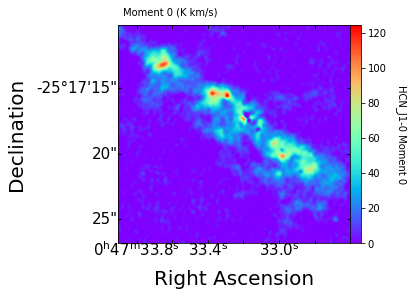

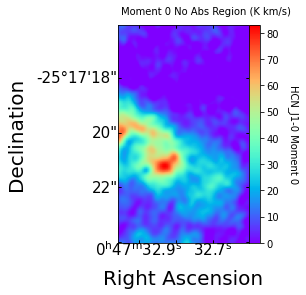

-inf
JJ nan 1 / cm2


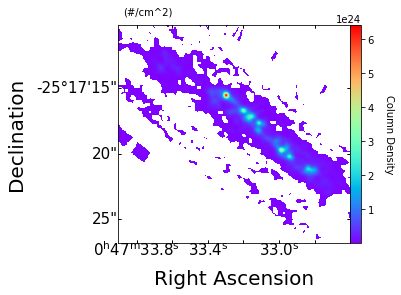

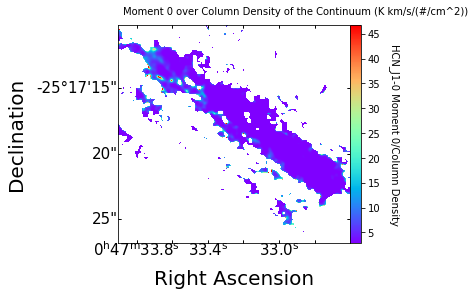

17.628552768208422
[26] [14] (34, 46)
<class 'float'> <class 'float'> 0.4117647058823529


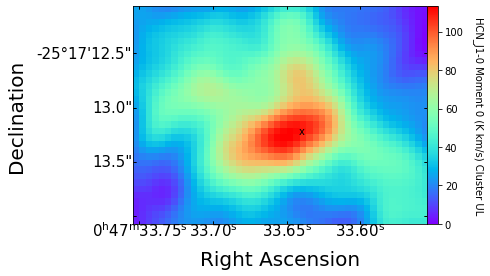

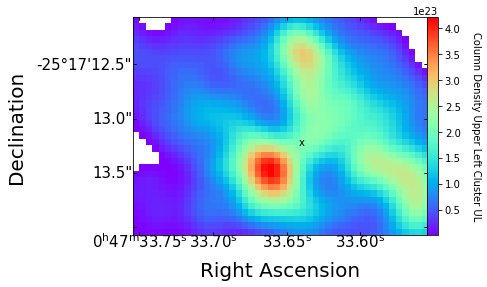

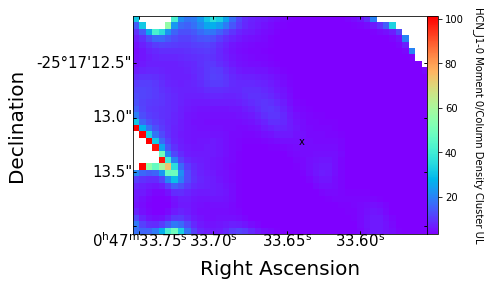

0.0022114475668164046

1 88631847000.0 Hz 0.003382446244181282 m
9.999999999999364e-13 <class 'float'>
0.29466400892442335 arcsec 0.29466400892442335 arcsec
28.32725000000179 pix2
0.00017608184354208866
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00338245 m>, 'data_unit': Unit("Jy / beam"), 'arc_per_pix_y': <Quantity 0.0589328 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.0589328 arcsec / pix>, 'beam_major': <Quantity 0.29466401 arcsec>, 'beam_minor': <Quantity 0.29466401 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 1.63702227e-05 deg>, 'velocity_scale': <Quantity 2.5 km / s>, 'vaxis': 0}
(238,) (62,)
0.1310782597510237
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00338245 m>, 'data_unit': Unit("Jy / beam"), 'arc_per_pix_y': <Quantity 0.0589328 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.0589328 arcsec / pix>, 'beam_major': <Quantity

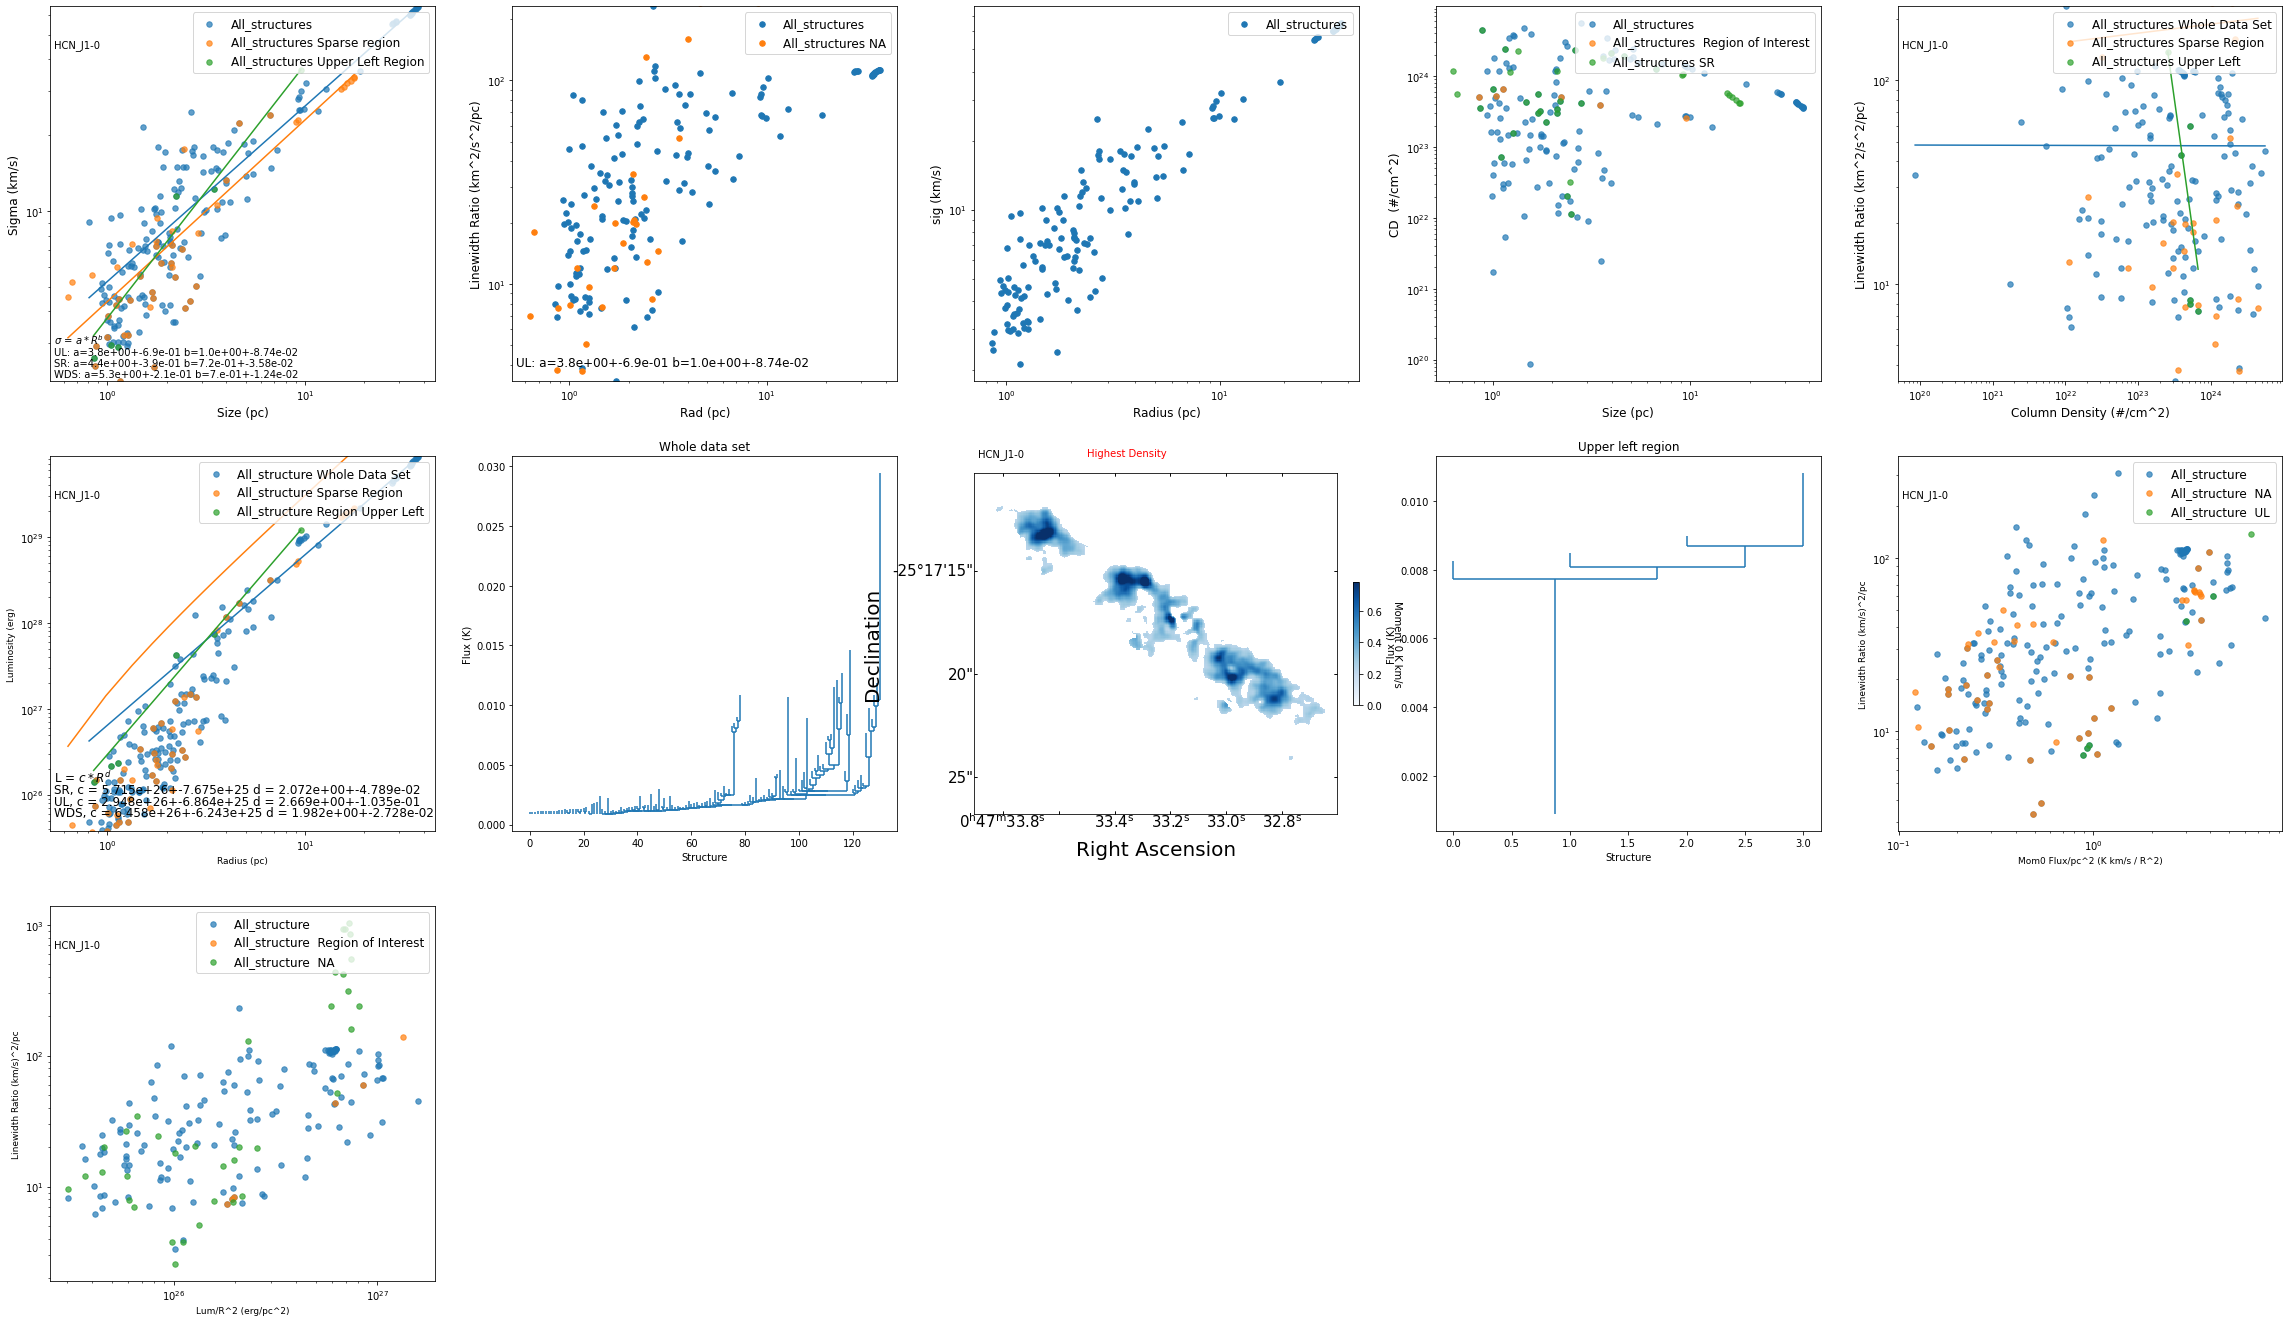

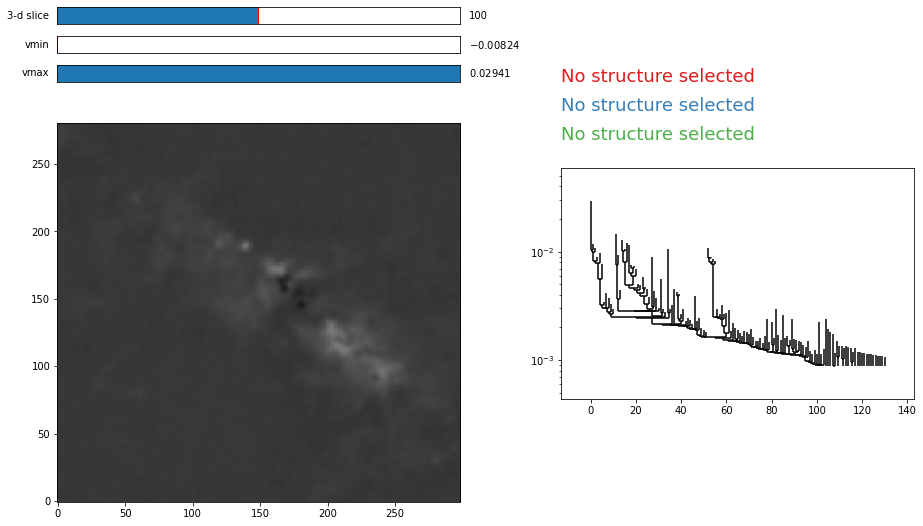

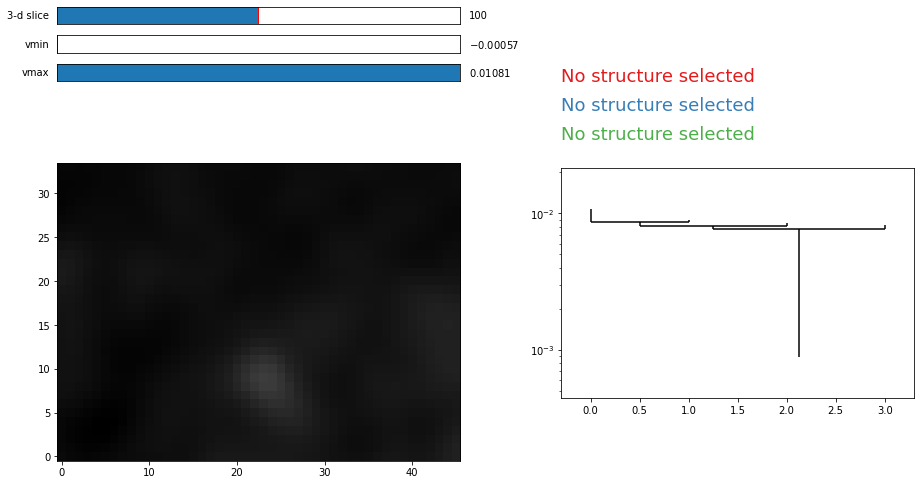

In [57]:
##### HCN_J1-0

Num=1
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN= "HCN_J1-0"
Name = "HCN-J1_Dend_Abs"
name ="HCN_J1_0_Countours_CM_Abs.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2




Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]

pathCont = 'Continuum_Reproject_5pc_beam.fits'#'Continuum_Reproject.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
print(m)
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc

    
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc



#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

scF = Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)

#Do the same thing to the continuum image
scContW =  Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)

print(np.shape(datn),np.shape(scCont))
#Cubes with little dense gas and abs
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmU[0][0])
######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=.1*10**22/u.cm**2)

bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=.1*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))




fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))

RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)
#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)



    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]
CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)





xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
#xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})



xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6


radgpFORRATUL = RconUL[gp2]*10**6
siggpFORRATUL = SconUL[gp2]
lumFORRATUL = LuminConUL[gp2]
mom0FORRATUL = MOM0FLUXconUL[gp2]

CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])




gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3UL = np.where(lumFORRATUL>0)
lumFORRATUL = lumFORRATUL[gp3UL]
rgpFORRATUL = rgpUL[gp3UL]
mom0FORRATUL = mom0FORRATUL[gp3UL]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]

print(poptUL,pcovUL,"Size Linewidth Upper Left Region:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity Upper Left Region:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)

xpconhhUL = ax5.scatter(radgpFORRATUL,cgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures Upper Left",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure Region Upper Left",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
st2 = "UL, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratUL = axLam.scatter(lumFORRATUL/radgpFORRATUL**2,rgpFORRATUL,label="All_structure  Region of Interest",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

gp4UL=np.where(MOM0FLUXconUL>0)
mom0FORFluxUL=MOM0FLUXconUL[gp4UL]
radgpFORFluxUL=RconUL[gp4UL]*10**6
rgpFORFluxUL=SconUL[gp4UL]**2/RconUL[gp4UL]/10**6

gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
mom0_ratUL = axDelta.scatter(mom0FORFluxUL/radgpFORFluxUL**2,rgpFORFluxUL,label="All_structure  UL",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



In [10]:
#CO 


Num=3
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2"
Name = "CO 3-2_Abs"
name = "CO_3_2_CM_Contours_DS_10_Abs.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

Names=np.load("Names.npy")
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_CO_J1_0.cube.reproject.K-kms.pbcor.fits'])
#path = "Cropped_NGC_Spliced_Reprojected_Whole_CO_32.fits"#paths[Num]
#path = "Cropped_NGC_Spliced_Reprojected_Whole_CO_32_No_Gauss_Corr.fits"#paths[Num]
#path = "Subtracted_Cropped_CO_3_2_NGC253.fits"

path = 'CO_3_2_NGC_Matched.fits'


pathCont = 'Continuum_Reproject.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
#m=.115
print(m,"N!")
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc


arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"PC per pix")


#Make subcube
#Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio").unmasked_copy()
Q = fits.open(path)[0]
Q.allow_huge_operations=True

Q.allow_huge_operations=True
#Q = Q*u.K**2
#Q.write(path,overwrite=True)
print(Q.data[0][0][0])
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')

sc = Q





m=.115
print(m,"Noise (K)")




#scQ = Q



dat = sc.data[int(len(sc.data)*((1-Ram_Limiter)/2)):int(len(sc.data)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

print(np.shape(dat))
center = SkyCoord('00h47m33.134s' ,'-25d17m19.68s',frame='icrs')
cen_p1 = SkyCoord('00h47m34.7s', '-25d17m31.467s', frame='icrs')
cen_p2 = SkyCoord('00h47m31.563s', '-25d17m7.815s', frame='icrs')



datn = dat[:,:,200:50]


#Do the same thing to the continuum image
#scContW =  Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)
scCont.allow_huge_operations=True
reheader = copy.deepcopy(sc.header)
reheader["CRPIX3"]=1
reheader["NAXIS"]=2
scContW = scCont.reproject(reheader)
print(np.shape(datn),np.shape(scCont),np.max(datn))
#Cubes with little dense gas and abs
#AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
#AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
AbpRAD1 = SkyCoord('00h47m32.9s', '-25d17m20.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.85s', '-25d17m19.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
#scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
scContNA= scCont.reproject(SCNA.moment0().header)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

#UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
#UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
UL1 = SkyCoord('00h47m33.6s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.58s', '-25d17m13.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
#UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)



SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
UpLeft = scCont.reproject(SCUL.moment0().header)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmU[0][0])
######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=7*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
#metadata["wcs"]= SpectralCube.WCS(scF.header)
metadata["vaxis"]=0
del scn
del dat
del Q
fig = plt.figure(1,figsize=(40,40))
vel,RA,Dec = scF.world[:,0,0]
#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1,"Mom 0 noise")
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)


#Make plot for the contours before I delete the cube to save space
del scF
d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit


d.save_to("CO_32_Dend.fits")
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*20,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*20,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit


Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))







axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)





p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters



#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True

'''
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            print(SIDS[0])
            print(SIDS[0][n])
            p1.plot_contour(axDelta, structure=int(SIDS[0][n]), lw=1, colors='red',label="Higest Density",alpha=1)
        else:
            p1.plot_contour(axDelta, structure=int(SIDS[0][n]), lw=1, colors='red',alpha=1)

'''
RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)
#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)



    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]

CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6


radgpFORRATUL = RconUL[gp2]*10**6
siggpFORRATUL = SconUL[gp2]
lumFORRATUL = LuminConUL[gp2]
mom0FORRATUL = MOM0FLUXconUL[gp2]



CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])




xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3UL = np.where(lumFORRATUL>0)
lumFORRATUL = lumFORRATUL[gp3UL]
rgpFORRATUL = rgpUL[gp3UL]
mom0FORRATUL = mom0FORRATUL[gp3UL]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]

print(poptUL,pcovUL,"Size Linewidth Upper Left Region:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity Upper Left Region:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)

xpconhhUL = ax5.scatter(radgpFORRATUL,cgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures Upper Left",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure Region Upper Left",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
st2 = "UL, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratUL = axLam.scatter(lumFORRATUL/radgpFORRATUL**2,rgpFORRATUL,label="All_structure  Region of Interest",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

gp4UL=np.where(MOM0FLUXconUL>0)
mom0FORFluxUL=MOM0FLUXconUL[gp4UL]
radgpFORFluxUL=RconUL[gp4UL]*10**6
rgpFORFluxUL=SconUL[gp4UL]**2/RconUL[gp4UL]/10**6

gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
mom0_ratUL = axDelta.scatter(mom0FORFluxUL/radgpFORFluxUL**2,rgpFORFluxUL,label="All_structure  UL",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



CO 3-2_Abs
Cropped_NGC_Spliced_Reprojected_Whole_CO_32.fits
0.003812077760408146 N!
5.999999999999992e-07 PC per pix
0.115 Noise (K)
(20, 1348, 1704)


NameError: name 'scn' is not defined

In [4]:
#CO 


Num=3
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J3-2"
Name = "CO 3-2_Abs"
name = "CO_3_2_CM_Contours_DS_10_Abs.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

Names=np.load("Names.npy")
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_CO_J1_0.cube.reproject.K-kms.pbcor.fits'])
path = "NGC_Spliced_Reprojected_Whole_CO_32.fits"#paths[Num]
path="Cropped_"+path



path = 'Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits'

pathCont = 'Continuum_Reproject.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
#m=.115
print(m,"N!")
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc

    
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"PC per pix")


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True

Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()
m = np.nanmean(np.nanstd(sc.hdu.data,axis=0)) #Noise K
#m=.115
print(m,"Noise (K)")

#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

scF = scn#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)

#Do the same thing to the continuum image
#scContW =  Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
print(np.shape(datn),np.shape(scCont),np.max(datn))
#Cubes with little dense gas and abs
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
#scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
scContNA= scCont.reproject(SCNA.moment0().header)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
#UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)



SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
UpLeft = scCont.reproject(SCUL.moment0().header)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmU[0][0])
######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=7*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=7*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*5,min_delta=m,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))




fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
scCropped[bp]=np.nan
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True
'''
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            print(SIDS[0])
            print(SIDS[0][n])
            p1.plot_contour(axDelta, structure=int(SIDS[0][n]), lw=1, colors='red',label="Higest Density",alpha=1)
        else:
            p1.plot_contour(axDelta, structure=int(SIDS[0][n]), lw=1, colors='red',alpha=1)
'''
RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)
#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)



    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]

CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6


radgpFORRATUL = RconUL[gp2]*10**6
siggpFORRATUL = SconUL[gp2]
lumFORRATUL = LuminConUL[gp2]
mom0FORRATUL = MOM0FLUXconUL[gp2]



CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])




xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3UL = np.where(lumFORRATUL>0)
lumFORRATUL = lumFORRATUL[gp3UL]
rgpFORRATUL = rgpUL[gp3UL]
mom0FORRATUL = mom0FORRATUL[gp3UL]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]

print(poptUL,pcovUL,"Size Linewidth Upper Left Region:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity Upper Left Region:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)

xpconhhUL = ax5.scatter(radgpFORRATUL,cgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures Upper Left",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure Region Upper Left",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
st2 = "UL, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratUL = axLam.scatter(lumFORRATUL/radgpFORRATUL**2,rgpFORRATUL,label="All_structure  Region of Interest",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

gp4UL=np.where(MOM0FLUXconUL>0)
mom0FORFluxUL=MOM0FLUXconUL[gp4UL]
radgpFORFluxUL=RconUL[gp4UL]*10**6
rgpFORFluxUL=SconUL[gp4UL]**2/RconUL[gp4UL]/10**6

gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
mom0_ratUL = axDelta.scatter(mom0FORFluxUL/radgpFORFluxUL**2,rgpFORFluxUL,label="All_structure  UL",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



CO 3-2_Abs
Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits
0.003812077760408146 N!
5.999999999999992e-07 PC per pix
0.6118052866779115 Noise (K)
(201, 795, 1006) (201, 795, 1006)
(201, 795, 1006) (469, 551) nan


NameError: name 'Crop' is not defined

In [6]:
#Fix reprojected repeated pixels

paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_CO_J1_0.cube.reproject.K-kms.pbcor.fits'])

pathCO = paths[3]
#pathCO = "NGC_Spliced_Reprojected_Whole_CO_32.fits"
pathCO = "NGC_Spliced_Reprojected_Whole_CO_32_No_Gauss_Corr.fits"
sc = SpectralCube.read(pathCO).with_spectral_unit(u.km/u.s,velocity_convention="radio")
sp=0
for lmi in range(len(sc)):
    if(np.round(np.nanmean(sc[lmi].hdu.data),5)==np.round(np.nanmean(sc[lmi+1].hdu.data),5)):
        
        sp = lmi+1
    else:
        print("A")
        print(lmi,np.nanmean(sc[lmi].hdu.data),np.nanmean(sc[lmi+1].hdu.data))
        break
l = len(sc)-1
ep=l
for lmi in range(l):

    if(np.round(np.nanmean(sc[l-lmi].hdu.data),5)==np.round(np.nanmean(sc[l-lmi-1].hdu.data),5)):
        ep = l-lmi-1
        
    else:
        print("B",lmi)
        break
        
print(sp,ep)
#unit = SpectralCube.read("NGC253.band7.TP+12m-mid+12m-high.CO_3-2.image.pbcor.fits")[0][0][0].unit
sc.allow_huge_operations=True
sc = sc[sp:ep]#*unit

sc.write(("Cropped_"+pathCO),overwrite=True)
print("Done")

A
7 -0.012759396398693088 -0.0020758205573519857
B 0
7 200
Done


CO 1-0_Abs
Fixed_NGC_CO_J1_0.cube.reproject.K-kms.pbcor.fits
3.8158561849602988
6.399999999999967e-06 PC per pix
(201, 125, 158) (201, 125, 158)
(201, 125, 158) (125, 158) 47.329472116707684
(201, 21, 13)


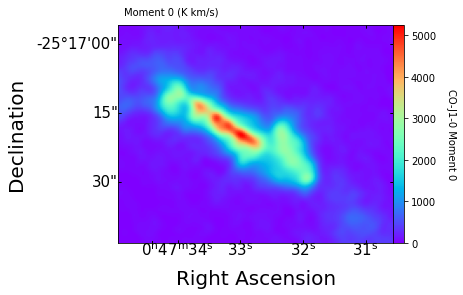

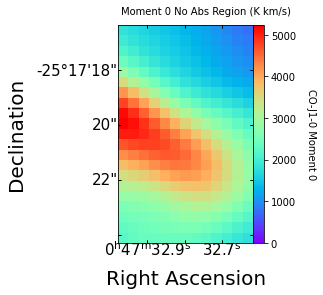

JJ nan 1 / cm2


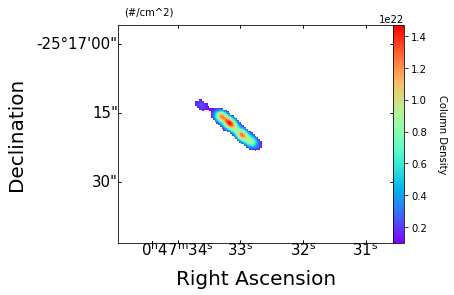

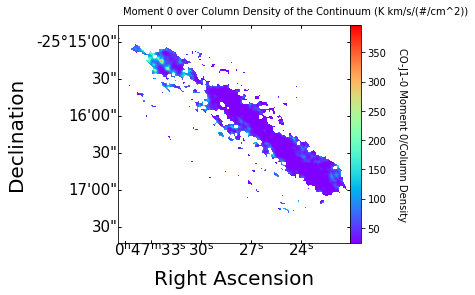

599052.229208681
[3] [3] (6, 7)
<class 'float'> <class 'float'> 0.5


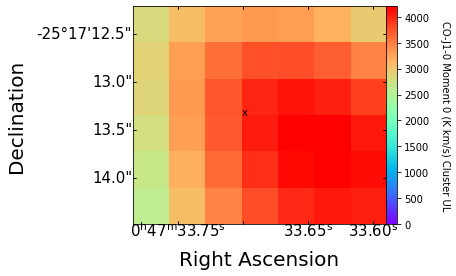

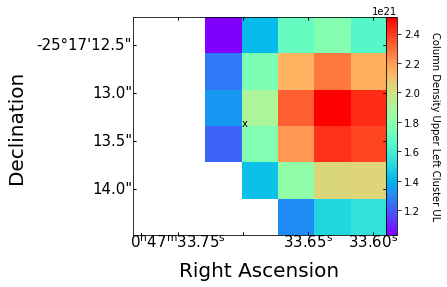

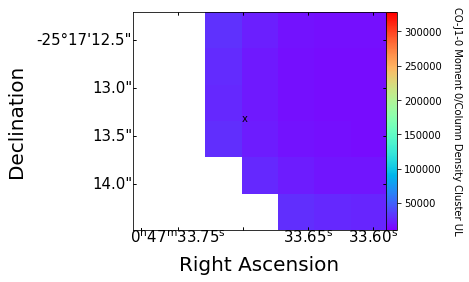

0.015737784487060157

1 115271200000.0 Hz 0.0026007576740764387 m
4.095999999999958e-11 <class 'float'>
1.885849657116307 arcsec 1.885849657116307 arcsec
28.32725000000021 pix2
3.8158561849602988
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00260076 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 0.37716993 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.37716993 arcsec / pix>, 'beam_major': <Quantity 1.88584966 arcsec>, 'beam_minor': <Quantity 1.88584966 arcsec>, 'beam_area_ratio': <Quantity 28.32725 pix2>, 'spatial_scale': <Quantity 0.00010477 deg>, 'velocity_scale': <Quantity 2.5 km / s>, 'vaxis': 0}
(19,) (3,)
766.789749572894
{'distance': <Quantity 3.5 Mpc>, 'beam_area_ratioc': <Quantity 28.32725 pix2>, 'wavelength': <Quantity 0.00260076 m>, 'data_unit': Unit("K"), 'arc_per_pix_y': <Quantity 0.37716993 arcsec / pix>, 'arc_per_pix_x': <Quantity 0.37716993 arcsec / pix>, 'beam_major': <Quantity 1.88584966 arcsec>, 'beam_

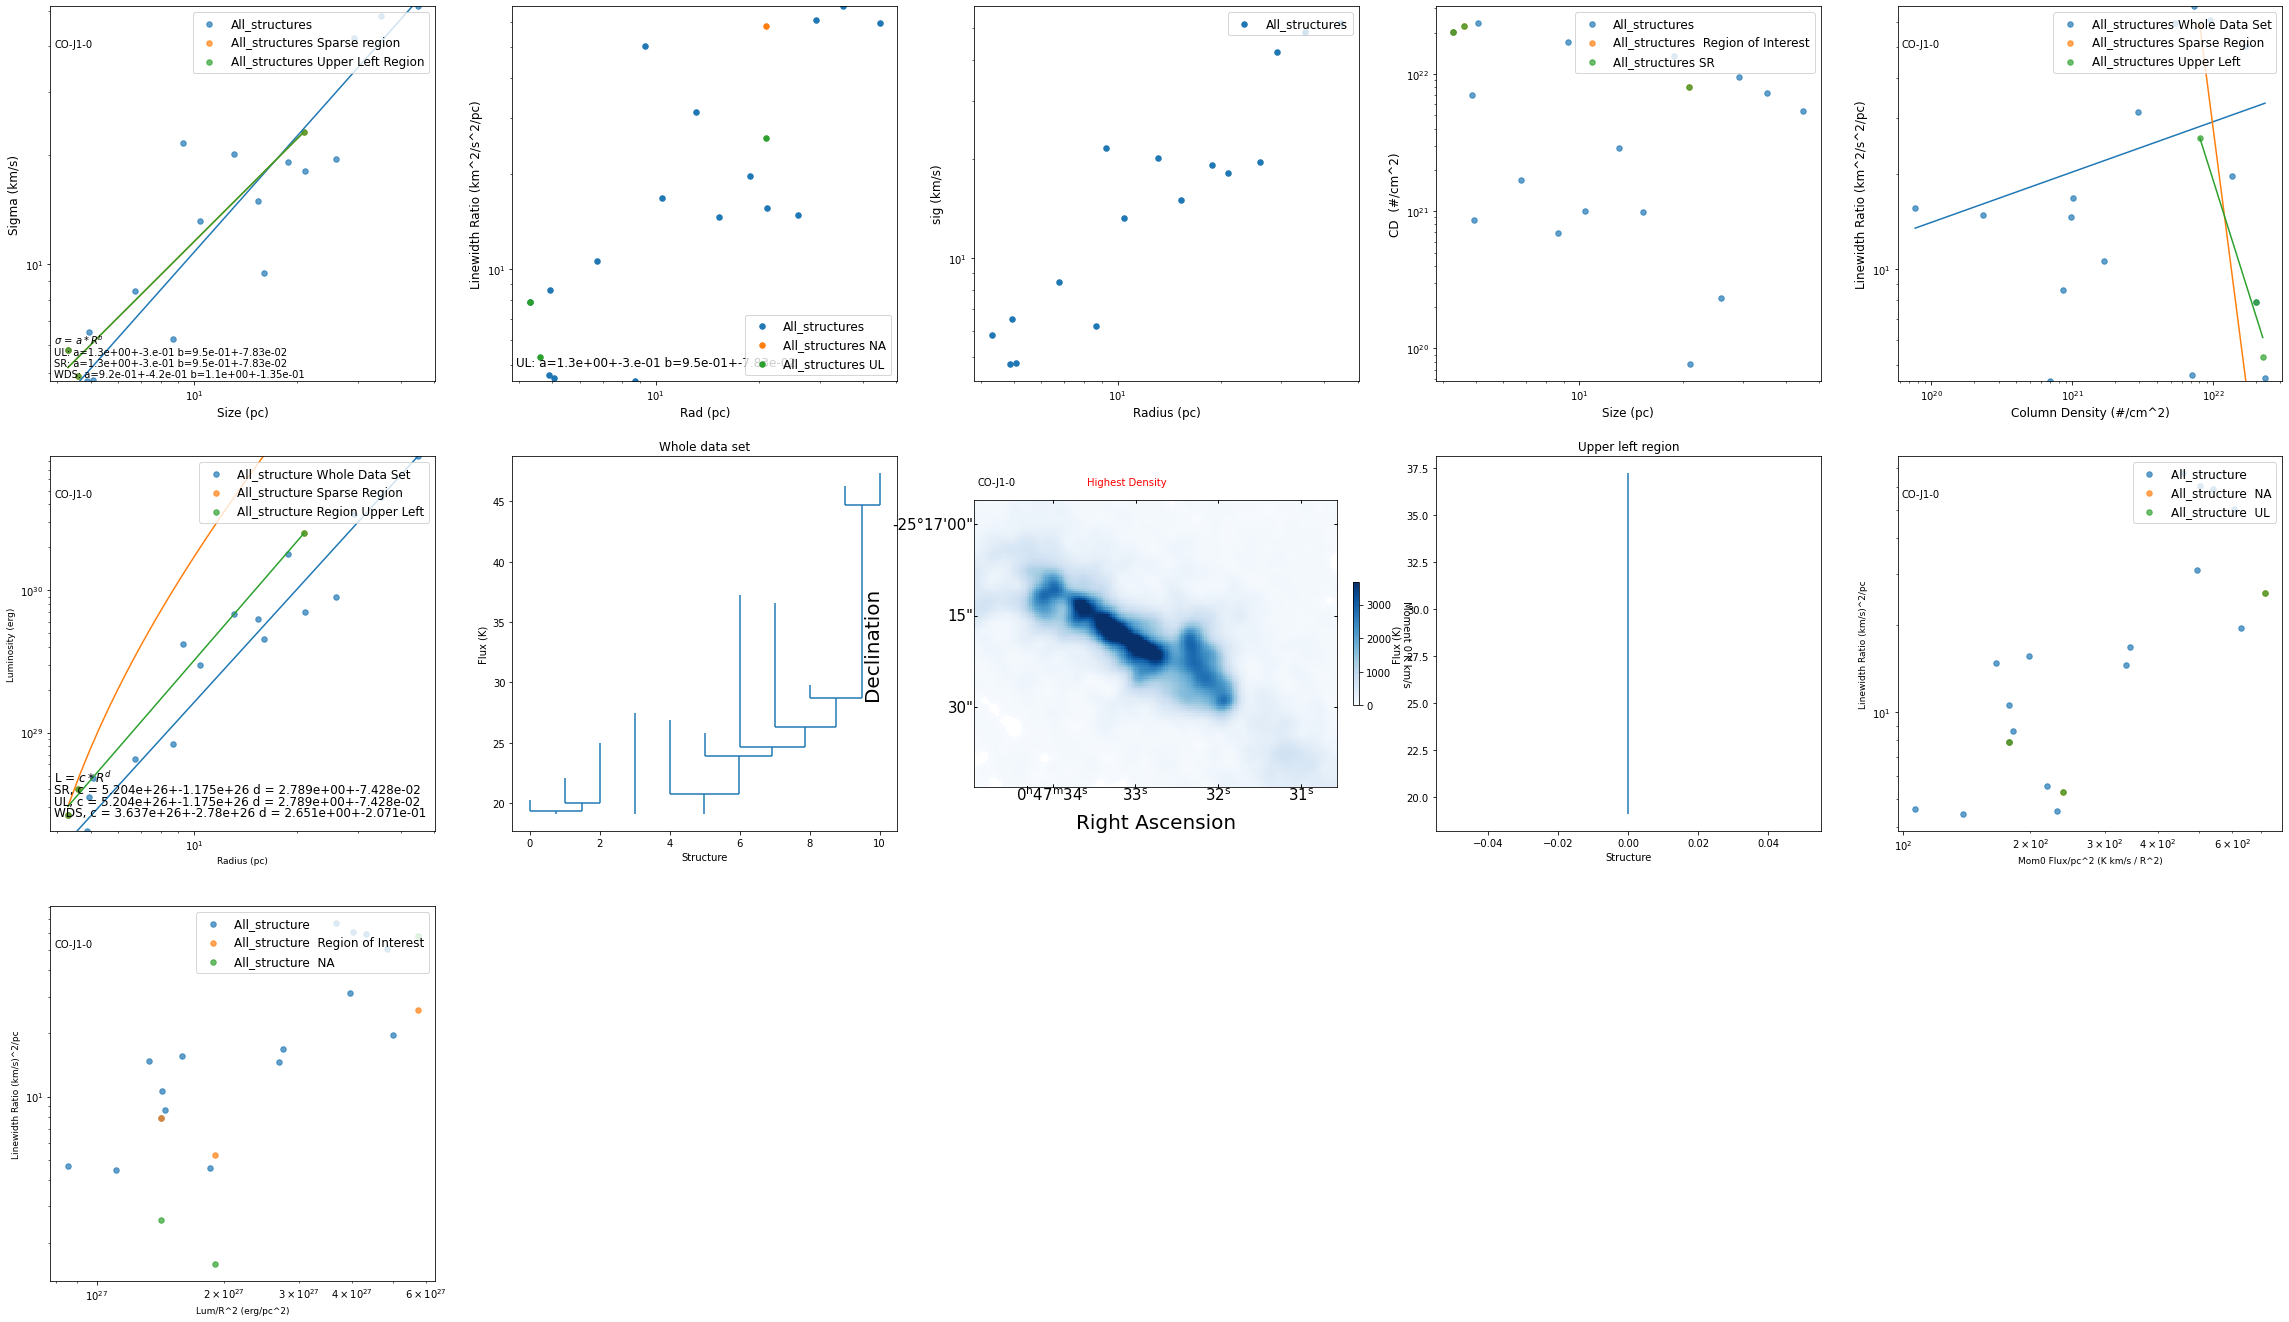

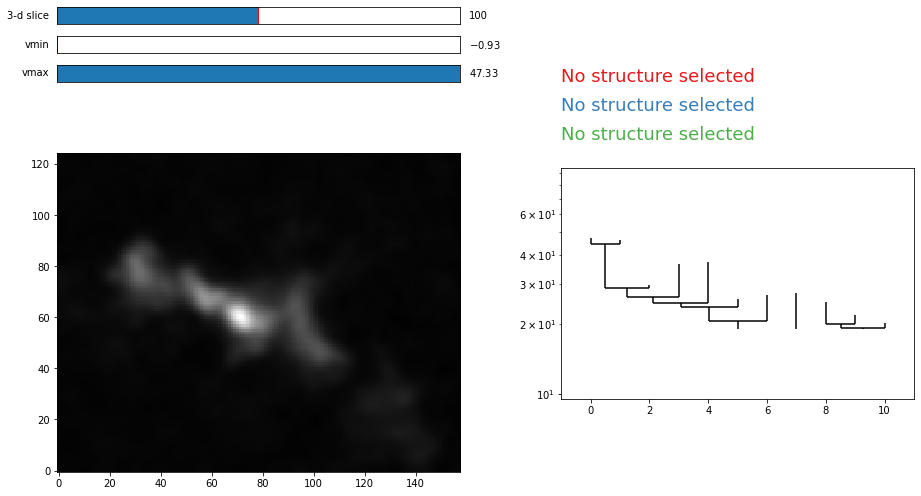

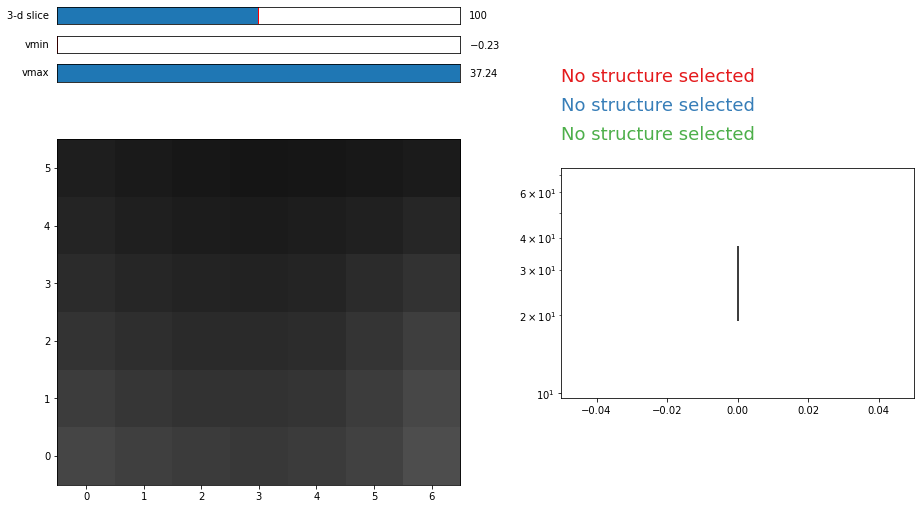

In [60]:
#CO 1-0


Num=11
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
LineN="CO-J1-0"
Name = "CO 1-0_Abs"
name = "CO_1_0_CM_Contours_DS_10_Abs.jpeg"
Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

Names=np.load("Names.npy")
Names[Num] = Name
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")

np.save("Names",Names)

print(Name)


paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_CO_J1_0.cube.reproject.K-kms.pbcor.fits'])
path = paths[Num]

pathCont = 'Continuum_Reproject_32pc_beam.fits'
#path='HCOp_J1-0.cube.fits'
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
#m=.115
print(m)
#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Put this up here for the column density map
metadata = {}
metadata["distance"] = 3.5*u.Mpc

    
arc_per_pix_yc =  abs(scCont.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scCont.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scCont.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scCont.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scCont.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
print(pc_per_pixelc,"PC per pix")


#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp

sc = Q.unmasked_copy()
#scQ = Q
scW = sc.wcs[:][:][0]


dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(scn))
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

scF = scn#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)

#Do the same thing to the continuum image
scContW =  scCont#Crop(scCont,scCont.wcs,cen_p1,cen_p2,5,True)

print(np.shape(datn),np.shape(scCont),np.max(datn))
#Cubes with little dense gas and abs
AbpRAD1 = SkyCoord('00h47m32.95s', '-25d17m24.0s', frame='icrs')
AbpRAD2 = SkyCoord('00h47m32.6s', '-25d17m16.0s', frame='icrs')
SCNA= Crop(scn,scn.wcs[:][:][0],AbpRAD1,AbpRAD2,0,False)
scContNA = Crop(scCont,scCont.wcs,AbpRAD1,AbpRAD2,0,True)
datna = SCNA.hdu.data 
print(np.shape(SCNA))

UL1 = SkyCoord('00h47m33.75s', '-25d17m14.0s', frame='icrs')
UL2 = SkyCoord('00h47m33.55s', '-25d17m12.0s', frame='icrs')
scWCS = scF.wcs[:][:][0]
scWCSNA = SCNA.wcs[:][:][0]
moment_0_subNA  = SCNA.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
UpLeft = Crop(scCont,scCont.wcs,UL1,UL2,5,True)
SCUL = Crop(scn,scn.wcs[:][:][0],UL1,UL2,0,False)
moment_0_UL = SCUL.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 
######Moment 0 for both
######and cont
Make_Plot((LineN+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)
#Make_Plot("Continuum","Continuum (Jy/Beam)",scContW.hdu.data,0,np.nanmax(scCont.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0"),"Moment 0 No Abs Region (K km/s)",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),moment_0_subNA.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number

######ratio
    
Np1 = SkyCoord('00h47m32.7s', '-25d17m26.5s', frame='icrs')#These are away from the clusters
Np2 = SkyCoord('00h47m32.5s', '-25d17m25.5s', frame='icrs')
NraDP1 = [int(scContW.wcs.world_to_pixel(Np1)[0]),int(scContW.wcs.world_to_pixel(Np1)[1])]
NraDP2 = [int(scContW.wcs.world_to_pixel(Np2)[0]),int(scContW.wcs.world_to_pixel(Np2)[1])]
    
bp = np.where(cSD<=.1*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
cSD[bp]=np.nan
print("JJ",cSD[0][0])
#Make_Plot("HCO+ Moment 0/Column Density","Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",moment_0_subNA.hdu.data,0,np.nanmax(moment_0_subNA.hdu.data),scCont.wcs,1,1,1,True)
Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)
Make_Plot((LineN+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)

#Region of interest in upper left
cSDUL = (Flux_to_Mass(UpLeft.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number
rmUL=moment_0_UL.hdu.data/cSDUL
rmUUL = rmUL*u.K*u.km/u.s#Just put back in the units
rmUUL = np.array(rmUUL /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all
print(rmUUL[0][0])
######ratio
    
bpul = np.where(cSDUL<=.1*10**22/u.cm**2)
bp2ul = np.where( moment_0_UL.hdu.data < .22)

cSDUL[bpul]=np.nan
rmUUL[bpul]=np.nan
rmUUL[bp2ul]=np.nan

z,yf,xf = np.where(SCUL.hdu.data==np.nanmax(SCUL.hdu.data))
print(xf,yf,np.shape(UpLeft.hdu.data))
xf,yf = float(xf/np.shape(UpLeft.hdu.data)[1]),float(yf/np.shape(UpLeft.hdu.data)[0])
print(type(xf),type(.5),yf)
Make_Plot_Anno((LineN+" Moment 0 (K km/s) Cluster UL"),"x",moment_0_UL.hdu.data,0,np.nanmax(moment_0_UL.hdu.data),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno("Column Density Upper Left Cluster UL","x",cSDUL,float(np.nanmin(cSDUL*u.cm**2)),float(np.nanmax(cSDUL*u.cm**2)),UpLeft.wcs,1,1,1,True,xf,yf)
Make_Plot_Anno((LineN+" Moment 0/Column Density Cluster UL"),"x",rmUUL,np.nanmean(rmUUL)*.5,abs(np.nanmean(rmUUL))*15,UpLeft.wcs,1,1,1,True,xf,yf)


print(np.nanmin(rmU))



header = scF.hdu.header
print()
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*3.5)**2#mpc^2/pix^2
print(area_res,type(area_res))

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m/5,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
print(m)
dNA = astrodendro.Dendrogram.compute(datna,min_value=m*5,min_delta=m/5,min_npix=beam_area_ratio.value) #The main culprit
dUL = astrodendro.Dendrogram.compute(SCUL.hdu.data,min_value=m*5,min_delta=m/5,min_npix=beam_area_ratio.value) #The main culprit

vel,RA,Dec = scF.world[:,0,0]
Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,scContW.hdu.data,metadata)

##Analyze dendograms
print(np.shape(d),np.shape(dNA))




fig = plt.figure(1,figsize=(40,40))


axAlpha = pylab.subplot(5, 5, 7)
axBeta = pylab.subplot(5, 5, 8)
axGamma = pylab.subplot(5, 5, 9)
axDelta = pylab.subplot(5, 5, 10)




p1=d.plotter()
p1.plot_tree(axAlpha)
axAlpha.set_xlabel("Structure")
axAlpha.set_ylabel("Flux (K)")
axAlpha.set_title("Whole data set")


p=dNA.plotter()
p.plot_tree(axBeta)
axBeta.set_xlabel("Structure")
axBeta.set_ylabel("Flux (K)")
axBeta.set_title("No absorption region")


p=dUL.plotter()
p.plot_tree(axGamma)
axGamma.set_xlabel("Structure")
axGamma.set_ylabel("Flux (K)")
axGamma.set_title("Upper left region")


#Plot contours for the top ten clusters


#scCropped =scF.moment0().hdu.data
scCropped =scF.moment0().hdu.data
scCropped[np.where(scF.moment0().hdu.data<.22)]=np.nan
print(np.nanmean(np.nanstd(scF.moment0().hdu.data))*1)
axDelta = pylab.subplot(5,5,8,projection=scF.moment0().wcs)
#axBeta.imshow(scCropped.moment0().hdu.data, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,norm=colors.LogNorm(vmin=5))
imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )



ColumnCon= np.concatenate((CD[0],CD[1]))
SIDScon = np.concatenate((SIDS[0],SIDS[1]))
nth =0# sorted(CD[0])[len(CD[0])-20]

G1 = True
'''
for n in range(len(CD[0])):
    
    if(CD[0][n]>=nth):
        #print(n,SIDS[0])
        if(G1):
            G1=False
            print(SIDS[0])
            print(SIDS[0][n])
            p1.plot_contour(axDelta, structure=int(SIDS[0][n]), lw=1, colors='red',label="Higest Density",alpha=1)
        else:
            p1.plot_contour(axDelta, structure=int(SIDS[0][n]), lw=1, colors='red',alpha=1)
'''
RA = axDelta.coords[0]                                                                  # 
Dec = axDelta.coords[1]

RA.set_ticks(size=-3)                                                                                      
Dec.set_ticks(size=-3) 
RA.set_ticklabel(exclude_overlapping=True) 
Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
pylab.ylabel('Declination',fontsize=20,labelpad=1)
axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
cb=pylab.colorbar(imBeta,fraction=0.016,pad=0.04)                                     
cb.set_label(label="Moment 0 K km/s",fontsize=10,rotation=270,labelpad=20) 
cb.ax.tick_params(which = 'major', labelsize = 10)   
pylab.annotate(s=LineN,fontsize=10,xy=(.01,1.05),xycoords="axes fraction",c="black")  
pylab.annotate(s="Highest Density",fontsize=10,xy=(.31,1.05),xycoords="axes fraction",c="red")  

    


pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix


#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]


RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA = Dendro_Arrays(dNA,datna,vel,scContNA.hdu.data,metadata)
RadsUL,SigmasUL,CDUL,LuminUL,SIDSUL,MOM0FLUXUL = RadsNA,SigmasNA,CDNA,LuminNA,SIDSNA,MOM0FLUXNA#Dendro_Arrays(dUL,SCUL.hdu.data,vel,UpLeft.hdu.data,metadata)
#def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata):
    

from scipy.optimize import curve_fit
from scipy.optimize import leastsq

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, Rads[0]*10**6,Sigmas[0])
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func,  Rads[1]*10**6,Sigmas[1])
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]


    
Rcon = np.concatenate((Rads[0],Rads[1]))
Scon = np.concatenate((Sigmas[0],Sigmas[1]))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)





RconNA = np.concatenate((RadsNA[0],RadsNA[1]))
SconNA = np.concatenate((SigmasNA[0],SigmasNA[1]))
print(np.shape(RconNA))
poptConNA, pcovConNA = curve_fit(func, RconNA*10**6, SconNA)



    
RconUL = np.concatenate((RadsUL[0],RadsUL[1]))
SconUL = np.concatenate((SigmasUL[0],SigmasUL[1]))

poptUL, pcovUL = curve_fit(func, RconUL*10**6, SconUL)



xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])

xsNA = np.linspace(np.nanmin(RconNA*10**6),np.nanmax(RconNA*10**6),50)
ysNA = func(xsNA,poptConNA[0],poptConNA[1])

LuminCon = np.concatenate((Lumin[0],Lumin[1]))
ColumnCon= np.concatenate((CD[0],CD[1]))

LuminConNA = np.concatenate((LuminNA[0],LuminNA[1]))
ColumnConNA= np.concatenate((CDNA[0],CDNA[1]))

MOM0FLUXcon = np.concatenate((MOM0FLUX[0],MOM0FLUX[1]))
MOM0FLUXconNA = np.concatenate((MOM0FLUXNA[0],MOM0FLUXNA[1]))
MOM0FLUXconUL = np.concatenate((MOM0FLUXUL[0],MOM0FLUXUL[1]))
#Flux ratios fit
#FRpopt,FRpcov = curve_fit(func, abs(FRs),Scon**2/Rcon/10**6)
#xsF=np.linspace(np.nanmin(abs(FRs)),np.nanmax(abs(FRs)),50)
#ysF = func(xsF,FRpopt[0],FRpopt[1])

#Radius Luminosity fit
gp = np.where(LuminCon>0)
print(np.shape(Rcon),np.shape(LuminCon))
lgp = LuminCon[gp]
radgp = Rcon[gp]*10**6
#print(np.shape(Rcon[gp]*10**6),np.shape(LuminCon[gp]))
RLpopt,RLpcov = curve_fit(func, np.array(radgp,dtype='float64'),np.array(lgp,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRL=np.linspace(np.nanmin(radgp),np.nanmax(radgp),50)
ysRL = func(xsRL,RLpopt[0],RLpopt[1])

gpNA = np.where(LuminConNA>0)
print(np.shape(RconNA),np.shape(LuminConNA))
lgpNA = LuminConNA[gpNA]
radgpNA = RconNA[gpNA]*10**6
RLpoptNA,RLpcovNA = curve_fit(func, np.array(radgpNA,dtype='float64'),np.array(lgpNA,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLNA=np.linspace(np.nanmin(radgpNA),np.nanmax(radgpNA),50)
ysRLNA = func(xsRL,RLpoptNA[0],RLpoptNA[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnCon>0)
cgp = ColumnCon[gp2]
rgp=Scon[gp2]**2/Rcon[gp2]/10**6
radgpFORRAT = Rcon[gp2]*10**6
siggpFORRAT = Scon[gp2]
lumFORRAT = LuminCon[gp2]
mom0FORRAT = MOM0FLUXcon[gp2]

CDpopt,CDpcov = curve_fit(func, np.array(cgp,dtype='float64') ,np.array(rgp,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCD=np.linspace(np.nanmin(cgp),np.nanmax(cgp),50)
ysCD = func(xsCD,CDpopt[0],CDpopt[1])


#Column density to Size-linewidth NA
gp2NA = np.where(ColumnConNA>0)
cgpNA = ColumnConNA[gp2NA]
rgpNA=SconNA[gp2NA]**2/Rcon[gp2NA]/10**6
radgpFORRATNA = RconNA[gp2NA]*10**6
siggpFORRATNA = SconNA[gp2NA]
lumFORRATNA = LuminConNA[gp2NA]
mom0FORRATNA = MOM0FLUXconNA[gp2NA]
CDpoptNA,CDpcovNA = curve_fit(func, np.array(cgpNA,dtype='float64') ,np.array(rgpNA,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDNA=np.linspace(np.nanmin(cgpNA),np.nanmax(cgpNA),50)
ysCDNA = func(xsCDNA,CDpoptNA[0],CDpoptNA[1])

print(poptCon,pcovCon,"Size Linewidth All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

print(poptCon,pcovCon,"Size Linewidth All_structures No abs:")
print("a = ",poptConNA[0],"+-",np.sqrt(pcovConNA[0][0]))
print("b = ",poptConNA[1],"+-",np.sqrt(pcovConNA[1][1]))

print(RLpopt,RLpcov,"Radius to Luminosity:")
print("c = ",RLpopt[0],"+-",np.sqrt(RLpcov[0][0]))
print("d = ",RLpopt[1],"+-",np.sqrt(RLpcov[1][1]))


print(RLpopt,RLpcov,"Radius to Luminosity No Abs:")
print("c = ",RLpoptNA[0],"+-",np.sqrt(RLpcovNA[0][0]))
print("d = ",RLpoptNA[1],"+-",np.sqrt(RLpcovNA[1][1]))



print(CDpopt,CDpcov,"Column Density to linewidth^2/size:")
print("e = ",CDpopt[0],"+-",np.sqrt(CDpcov[0][0]))
print("f = ",CDpopt[1],"+-",np.sqrt(CDpcov[1][1]))



ax2 = pylab.subplot(5, 5, 1)
ax3 = pylab.subplot(5, 5, 2)
ax4 = pylab.subplot(5, 5, 3)



print(np.shape(Rcon*10**6),np.shape(Scon),np.shape(Rads[0]*10**6),np.shape(Sigmas[0]),np.shape(Rads[1]*10**6),np.shape(Sigmas[1]),type(Rads[0]))
#xpcon,xpL,xpB = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30),ax2.scatter(Rads[0]*10**6,Sigmas[0],s=30),ax2.scatter(Rads[1]*10**6,Sigmas[1],s=30)
xpcon = ax2.scatter(Rcon*10**6,Scon,label="All_structures",s=30,alpha=.7)
#p,p2,p3 = ax2.plot(xs,ysCon),ax2.plot(xs,ysL),ax2.plot(xs,ysB)
p = ax2.plot(xs,ysCon)

pNA = ax2.plot(xsNA,ysNA)
xpNA = ax2.scatter(RconNA*10**6,SconNA,label="All_structures Sparse region",s=30,alpha=.7)

xpconhh = ax2.scatter(RconUL*10**6,SconUL,label="All_structures Upper Left Region",s=30,alpha=.7)
xsUL=np.linspace(np.nanmin(RconUL*10**6),np.nanmax(RconUL*10**6),50)
ysUL=func(xsUL,poptUL[0],poptUL[1])
p22 = ax2.plot(xsUL,ysUL)


st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
st="SR: a="+ str(np.format_float_scientific(poptConNA[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[0][0]),1))+" b="+str(np.format_float_scientific(poptConNA[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovConNA[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.04),xycoords="axes fraction")
st="UL: a="+ str(np.format_float_scientific(poptUL[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[0][0]),1))+" b="+str(np.format_float_scientific(poptUL[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovUL[1][1]),2))
ax2.annotate(s=st,fontsize=10,xy=(0.01,0.07),xycoords="axes fraction")
ax2.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax2.set_xlabel("Size (pc)",fontsize=12)
ax2.set_ylabel("Sigma (km/s)",fontsize=12)
ax2.legend(prop={'size': 12},loc="upper right")
ax2.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#gp = np.where(FRs>0)







xspL = ax4.scatter(radgpFORRAT,siggpFORRAT,label="All_structures",s=30)




ax4.set_yscale('log')
ax4.set_xscale('log')

ax4.set_xlabel("Radius (pc)",fontsize=12)
ax4.set_ylabel("sig (km/s)",fontsize=12)
ax4.legend(prop={'size': 12},loc="upper right")






LuminConUL = np.concatenate((LuminUL[0],LuminUL[1]))
ColumnConUL= np.concatenate((CDUL[0],CDUL[1]))

#Radius Luminosity fit
gp = np.where(LuminConUL>0)
lgpUL = LuminConUL[gp]
radgpUL = RconUL[gp]*10**6
print(np.shape(radgpUL),np.shape(lgpUL))
RLpoptUL,RLpcovUL = curve_fit(func, np.array(radgpUL,dtype='float64'),np.array(lgpUL,dtype='float64'),maxfev=999999,p0 = np.array([10**27,1],dtype='float64'),ftol = 10**-10)

xsRLUL=np.linspace(np.nanmin(radgpUL),np.nanmax(radgpUL),50)
ysRLUL = func(xsRLUL,RLpoptUL[0],RLpoptUL[1])

#Column density to Size-linewidth
gp2 = np.where(ColumnConUL>0)
cgpUL = ColumnConUL[gp2]
rgpUL=SconUL[gp2]**2/RconUL[gp2]/10**6


radgpFORRATUL = RconUL[gp2]*10**6
siggpFORRATUL = SconUL[gp2]
lumFORRATUL = LuminConUL[gp2]
mom0FORRATUL = MOM0FLUXconUL[gp2]

CDpoptUL,CDpcovUL = curve_fit(func, np.array(cgpUL,dtype='float64') ,np.array(rgpUL,dtype='float64'),maxfev=9999099,p0 = np.array([10,.01],dtype='float64'),ftol = 10**-10)
xsCDUL=np.linspace(np.nanmin(cgpUL),np.nanmax(cgpUL),50)
ysCDUL = func(xsCDUL,CDpoptUL[0],CDpoptUL[1])




xspF = ax3.scatter(radgpFORRAT,rgp,label="All_structures",s=30)
xspFNA = ax3.scatter(radgpFORRATNA,rgpNA,label="All_structures NA",s=30)
xspFUL = ax3.scatter(radgpFORRATUL,rgpUL,label="All_structures UL",s=30)

ax3.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax3.set_xlabel("Rad (pc)",fontsize=12)
ax3.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax3.legend(prop={'size': 12})

gp3 = np.where(lumFORRAT>0)
lumFORRAT = lumFORRAT[gp3]
rgpFORRAT = rgp[gp3]
mom0FORRAT = mom0FORRAT[gp3]

gp3UL = np.where(lumFORRATUL>0)
lumFORRATUL = lumFORRATUL[gp3UL]
rgpFORRATUL = rgpUL[gp3UL]
mom0FORRATUL = mom0FORRATUL[gp3UL]

gp3NA = np.where(lumFORRATNA>0)
lumFORRATNA = lumFORRATNA[gp3NA]
rgpFORRATNA = rgpNA[gp3NA]
mom0FORRATNA = mom0FORRATNA[gp3NA]

print(poptUL,pcovUL,"Size Linewidth Upper Left Region:")
print("a = ",poptUL[0],"+-",np.sqrt(pcovUL[0][0]))
print("b = ",poptUL[1],"+-",np.sqrt(pcovUL[1][1]))

print(RLpoptUL,RLpcovUL,"Radius to Luminosity Upper Left Region:")
print("c = ",RLpoptUL[0],"+-",np.sqrt(RLpcovUL[0][0]))
print("d = ",RLpoptUL[1],"+-",np.sqrt(RLpcovUL[1][1]))


ax5 = pylab.subplot(5, 5, 4)
ax6 = pylab.subplot(5, 5, 5)
ax7 = pylab.subplot(5, 5, 6)




xpconhh = ax5.scatter(radgpFORRAT,cgp,label="All_structures",s=30,alpha=.7)

xpconhhUL = ax5.scatter(radgpFORRATUL,cgpUL,label="All_structures  Region of Interest",s=30,alpha=.7)
xpconhhNA = ax5.scatter(radgpFORRATNA,cgpNA,label="All_structures SR",s=30,alpha=.7)

ax5.set_yscale('log')
ax5.set_xscale('log')
#ax5.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
ax5.set_xlabel("Size (pc)",fontsize=12)
ax5.set_ylabel("CD  (#/cm^2)",fontsize=12)
ax5.legend(prop={'size': 12},loc="upper right")


#gp = np.where(FRs>0)



xspFUL2 = ax6.scatter(cgp,rgp,label="All_structures Whole Data Set",s=30,alpha=.7)
pFUL2 = ax6.plot(xsCD,ysCD)


xspFNA = ax6.scatter(cgpNA,rgpNA,label="All_structures Sparse Region",s=30,alpha=.7)
pFNA = ax6.plot(xsCDNA,ysCDNA)


xspFUL = ax6.scatter(cgpUL,rgpUL,label="All_structures Upper Left",s=30,alpha=.7)
pFUL = ax6.plot(xsCDUL,ysCDUL)

#ax6.annotate(s=st,fontsize=12,xy=(0.01,0.06),xycoords="axes fraction")
ax6.set_yscale('log')
ax6.set_xscale('log')
ax6.set_ylim(np.nanmin(rgp),np.nanmax(rgp))
ax6.set_xlabel("Column Density (#/cm^2)",fontsize=12)
ax6.set_ylabel("Linewidth Ratio (km^2/s^2/pc)",fontsize=12)
ax6.legend(prop={'size': 12},loc="upper right")
ax6.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")




xspLu2 = ax7.scatter(radgp,lgp,label="All_structure Whole Data Set",s=30,alpha=.7)
pFLLu2 = ax7.plot(xsRL,ysRL)
xspLu2NA = ax7.scatter(radgpNA,lgpNA,label="All_structure Sparse Region",s=30,alpha=.7)
pFLLu2NA = ax7.plot(xsRLNA,ysRLNA)

xspLu = ax7.scatter(radgpUL,lgpUL,label="All_structure Region Upper Left",s=30,alpha=.7)

pFLLu = ax7.plot(xsRLUL,ysRLUL)


st = "WDS, c = "+ str(np.format_float_scientific(RLpopt[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[0][0]),3))+" d = "+str(np.format_float_scientific(RLpopt[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcov[1][1]),3))
ax7.annotate(s='L = $c*R^d$',fontsize=12,xy=(0.01,0.13),xycoords="axes fraction")
ax7.annotate(s=st,fontsize=12,xy=(0.01,0.04),xycoords="axes fraction")
st2 = "UL, c = "+ str(np.format_float_scientific(RLpoptUL[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptUL[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovUL[1][1]),3))
ax7.annotate(s=st2,fontsize=12,xy=(0.01,0.07),xycoords="axes fraction")

st3 = "SR, c = "+ str(np.format_float_scientific(RLpoptNA[0],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[0][0]),3))+" d = "+str(np.format_float_scientific(RLpoptNA[1],3))+"+-"+str(np.format_float_scientific(np.sqrt(RLpcovNA[1][1]),3))
ax7.annotate(s=st3,fontsize=12,xy=(0.01,0.10),xycoords="axes fraction")

ax7.set_yscale('log')
ax7.set_xscale('log')
ax7.set_ylim(np.nanmin(lgp),np.nanmax(lgp))
ax7.set_xlabel("Radius (pc)",fontsize=9)
ax7.set_ylabel("Luminosity (erg)",fontsize=9)
ax7.legend(prop={'size': 12},loc="upper right")
ax7.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")

#print(FRs)




axLam = pylab.subplot(5, 5, 11)
lum_rat = axLam.scatter(lumFORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  ",s=30,alpha=.7)
lum_ratUL = axLam.scatter(lumFORRATUL/radgpFORRATUL**2,rgpFORRATUL,label="All_structure  Region of Interest",s=30,alpha=.7)
lum_ratNA = axLam.scatter(lumFORRATNA/radgpFORRATNA**2,rgpFORRATNA,label="All_structure  NA",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axLam.set_yscale('log')
axLam.set_xscale('log')
axLam.set_xlabel("Lum/R^2 (erg/pc^2)",fontsize=9)
axLam.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axLam.legend(prop={'size': 12},loc="upper right")
axLam.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")



axDelta = pylab.subplot(5, 5, 10)



#mom0_rat = axDelta.scatter(mom0FORRAT/radgpFORRAT**2,rgpFORRAT,label="All_structure  Region of Interest",s=30,alpha=.7)
gp4=np.where(MOM0FLUXcon>0)
mom0FORFlux=MOM0FLUXcon[gp4]
radgpFORFlux=Rcon[gp4]*10**6
rgpFORFlux=Scon[gp4]**2/Rcon[gp4]/10**6

gp4UL=np.where(MOM0FLUXconUL>0)
mom0FORFluxUL=MOM0FLUXconUL[gp4UL]
radgpFORFluxUL=RconUL[gp4UL]*10**6
rgpFORFluxUL=SconUL[gp4UL]**2/RconUL[gp4UL]/10**6

gp4NA=np.where(MOM0FLUXconNA>0)
mom0FORFluxNA=MOM0FLUXconNA[gp4NA]
radgpFORFluxNA=RconNA[gp4NA]*10**6
rgpFORFluxNA=SconNA[gp4NA]**2/RconNA[gp4NA]/10**6


mom0_rat = axDelta.scatter(mom0FORFlux/radgpFORFlux**2,rgpFORFlux,label="All_structure  ",s=30,alpha=.7)
mom0_ratNA = axDelta.scatter(mom0FORFluxNA/radgpFORFluxNA**2,rgpFORFluxNA,label="All_structure  NA",s=30,alpha=.7)
mom0_ratUL = axDelta.scatter(mom0FORFluxUL/radgpFORFluxUL**2,rgpFORFluxUL,label="All_structure  UL",s=30,alpha=.7)
#Off by factors for area, simply using r^2

axDelta.set_yscale('log')
axDelta.set_xscale('log')
axDelta.set_xlabel("Mom0 Flux/pc^2 (K km/s / R^2)",fontsize=9)
axDelta.set_ylabel("Linewidth Ratio (km/s)^2/pc",fontsize=9)
axDelta.legend(prop={'size': 12},loc="upper right")
axDelta.annotate(s=LineN,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


pylab.show()



NameCol = (Name+"_Column")
NameLum = (Name+"_Luminosities")

NameColROI = (Name+"_Column_ROI")
NameLumROI = (Name+"_Luminosities_ROI")
NameRROI = (NameR+"_ROI")
NameSROI = (NameS+"_ROI")
NameFlux = (Name+"Flux_Dense")
NameRFF = (Name+"Rad_For_Flux")





v1 = d.viewer()
v1.show()
v3 = dUL.viewer()
v3.show()

np.save(NameCol,CD)
np.save(NameLum,Lumin)

np.save(NameS,Sigmas)
np.save(NameR,Rads) #Still in [leaves] [breanches] format

np.save(NameColROI,CDUL)
np.save(NameLumROI,LuminUL)

np.save(NameSROI,SigmasUL)
np.save(NameRROI,RadsUL) #Still in [leaves] [breanches] format

np.save(NameFlux,mom0FORFlux/radgpFORFlux**2)
np.save(NameRFF,rgpFORFlux)



['HCOp-J1_Dend_AbsRadii' 'HCN-J1_Dend_AbsRadii' 'H13CN-J1_AbsRadii'
 'CO 3-2_AbsRadii' '5' 'H13COp_1_0_AbsRadii' '7' '8' '9' '10' '11'] ['HCOp-J1_Dend_AbsSigmas' 'HCN-J1_Dend_AbsSigmas' 'H13CN-J1_AbsSigmas'
 'CO 3-2_AbsSigmas' '5' 'H13COp_1_0_AbsSigmas' '7' '8' '9' '10' '11'] CO 3-2_AbsRadii CO 3-2_AbsSigmas
CO 3-2_AbsSigmas
ngc253_co32_hires_common.fits
(81, 1536, 1800) (81, 1536, 1800) 9.063807777998229e-09 K
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    3 / number of array dimensions                     NAXIS1  =                 1800                                                  NAXIS2  =                 1536                                                  NAXIS3  =                   81                                                  BMAJ    =   4.861111111111E-05                                                  BMIN    =   4.86111111111

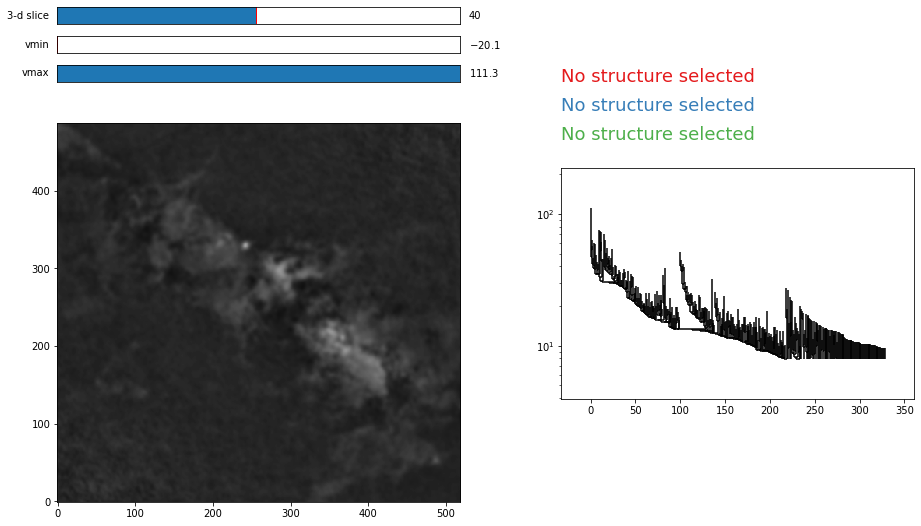

(107,)
[5.63500895 0.72400517] [[ 0.11841703 -0.00629858]
 [-0.00629858  0.00034329]] All_structures:
a =  5.6350089513119626 +- 0.3441177552352828
b =  0.7240051730985723 +- 0.01852809489076452


<Figure size 2160x2160 with 0 Axes>

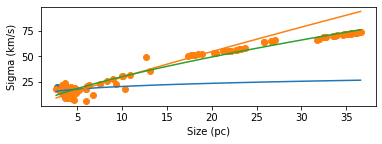

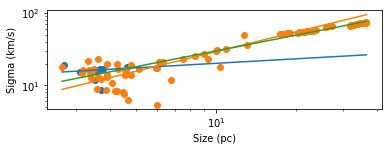

In [3]:
#size definitions from fwhm to 90% to gaussian (1sigma) 

#CO 


Num=3
Overlaps=0#4
Ram_Limiter=1#What percent of the cube my ram can handle
Name = "CO 3-2_Abs"
name = "CO_3_2_CM_Contours_DS_10_Abs.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
RNames=np.load('RNames.npy')
SNames=np.load('SNames.npy')

RNames[Num] = NameR
SNames[Num] = NameS
print(RNames,SNames,NameR,NameS)
np.save("RNames",RNames)
np.save("SNames",SNames)

print(NameS)
paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
#path = paths[Num]
path = 'ngc253_co32_hires_common.fits'
print(path)
Confidences = np.load('Confidence_data.npy')
H13CN_MASK = np.load('H13CN_MASK_NGC.npy')
Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp.spectral_slab(-50. *u.km / u.s, 500. *u.km / u.s)

sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
#BP = np.where(Confidences<Overlaps)#Overlaps)
del Confidences
#sc.hdu.data[BP]=np.nan
#print(sc.hdu.data[BP])
#del BP
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc),sc[0][0][0])
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars


del paths
vel, dec, ra = Q.world[:,0,0]           # For plotting purposes, I want to know the average velocity
#print(vel)
header = Q.hdu.header
print(header)
#print(header)
#make metadata for the dendrogram
metadata = {}
try:
    metadata['wavelength'] = header["RESTFREQ"]*u.Hz#
except:
    
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=int(4.8**2*1*3)) #The main culprit




##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-200. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
ds=30
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity

wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*12)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        Cont = True
        try:
            #print(str(t.descendants[0]).find("branch"))
            #print(str(t.descendants[0]))
            if(str(t.descendants[0]).find("branch") != -1):
                Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
        except:
            lop=12

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>4.8*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
            if((True)):
                for lmn in range(np.nanmax(I[0])-np.nanmin(I[0])):
                    p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = lmn)
                #p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1)
                #print(n)
                #ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                #ax.add_patch(ellipse)
                #print(t.indices())
                #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)

pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix
radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

for t in d.all_structures: 
    
    I = t.indices()
    Cont = True
    try:
        #print(str(t.descendants[0]).find("branch"))
        #print(str(t.descendants[0]))
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>4.8**2*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>4.8*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
        if(s.v_rms*s.radius**2>4.8**2*metadata["velocity_scale"]*u.pix**2*3):







            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)

Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)

print(poptCon,pcovCon,"All_structures:")
print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xpL,xpB = ax.scatter(radsL*10**6,sigmasL),ax.scatter(radsB*10**6,sigmasB)
xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])
xpa1,xpa2,xpaTot = ax.plot(xs,ysL),ax.plot(xs,ysB),ax.plot(xs,ysCon)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xpL,xpB = ax2.scatter(radsL*10**6,sigmasL),ax2.scatter(radsB*10**6,sigmasB)
p,p2,p3 = ax2.plot(xs,ysL),ax2.plot(xs,ysB),ax2.plot(xs,ysCon)
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()



In [ ]:
#Finding the manual contours

#CO


path = 'ngc253_co32_hires_common.fits'

Noises = np.load('Noises_K.npy')
#Noises = Ns
Num=3
m = Noises[Num]
#Make subcube
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio")
Qp.allow_huge_operations=True

Q = Qp.spectral_slab(-50. *u.km / u.s, 500. *u.km / u.s)

sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
#BP = np.where(Confidences<Overlaps)#Overlaps)
del Confidences
#sc.hdu.data[BP]=np.nan
#print(sc.hdu.data[BP])
#del BP
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc),sc[0][0][0])
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]

datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube




scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars


AP = np.load('Abs_Pix_NGC.npy')

BP = np.where(AP>0)

dat_No_Abs=np.copy(dat)
dat_No_Abs[BP]=np.nan
datn_NA = dat_No_Abs[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]]

del paths
vel, dec, ra = Q.world[:,0,0]           # For plotting purposes, I want to know the average velocity
#print(vel)
header = Q.hdu.header
print(header)
#print(header)
#make metadata for the dendrogram
metadata = {}
try:
    metadata['wavelength'] = header["RESTFREQ"]*u.Hz#
except:
    
metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc
metadata["vaxis"]=0

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=int(4.8**2*1*3)) #The main culprit
d_no_abs = astrodendro.Dendrogram.compute(datn_NA,min_delta = m,min_value = m*5, min_npix=beam_area_ratio.value,wcs = scQF.wcs) #The main culprit



##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-200. *u.km / u.s, 700. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity

wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*12)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        Cont = True
        try:
            #print(str(t.descendants[0]).find("branch"))
            #print(str(t.descendants[0]))
            if(str(t.descendants[0]).find("branch") != -1):
                Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
        except:
            lop=12

        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>1*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>4.8*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
            if((True)):
                for lmn in range(np.nanmax(I[0])-np.nanmin(I[0])):
                    p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = lmn)
                #p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1)
                #print(n)
                #ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                #ax.add_patch(ellipse)
                #print(t.indices())
                #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)

pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc

sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix
radsL=np.array([])
radsB=np.array([])
sigmasL=np.array([])
sigmasB=np.array([])

for t in d.all_structures: 
    
    I = t.indices()
    Cont = True
    try:
        #print(str(t.descendants[0]).find("branch"))
        #print(str(t.descendants[0]))
        if(str(t.descendants[0]).find("branch") != -1):
            Cont = False #If we find a branch inside this structure t, then it is at least order two and will be discarded
    except:
        lop=12
    
    if(Cont):
        s = PPVStatistic(t,metadata=metadata)
        #if(s.v_rms > 2*u.km/u.s and s.v_rms*s.radius**2>4.8**2*metadata["velocity_scale"]*u.pix**2*3 and s.radius<24*2*u.pix and s.radius>4.8*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 4):
        if(s.v_rms*s.radius**2>4.8**2*metadata["velocity_scale"]*u.pix**2*3):







            if(t.is_leaf):
                radsL=np.append(radsL,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasL=np.append(sigmasL,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)
            if(t.is_branch	):
                radsB=np.append(radsB,(float(s.radius*pc_per_pixel))) #convert pixel to pc (then make it dimensionless)
                sigmasB=np.append(sigmasB,(float(s.v_rms*u.s/u.km)))#Convert pixel to velocity (then make it dimensionless)



from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
try:
    popt, pcov = curve_fit(func, radsL*10**6, sigmasL)
except:
    popt, pcov = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]
try:
    poptB, pcovB = curve_fit(func, radsB*10**6, sigmasB)
except:
    poptB, pcovB = [np.nan,np.nan],[[np.nan,np.nan],[np.nan,np.nan]]

Rcon = np.concatenate((radsL,radsB))
Scon = np.concatenate((sigmasL,sigmasB))
print(np.shape(Rcon))
poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
try:
    print(popt,pcov,"leaves:")
    print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
    print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
    print(poptB,pcovB,"branches:")
    print("a = ",poptB[0],"+-",np.sqrt(pcovB[0][0]))
    print("b = ",poptB[1],"+-",np.sqrt(pcovB[1][1]))
    print(poptCon,pcovCon,"All_structures:")
    print("a = ",poptCon[0],"+-",np.sqrt(pcovCon[0][0]))
    print("b = ",poptCon[1],"+-",np.sqrt(pcovCon[1][1]))

    fig = plt.figure()
    ax = pylab.subplot(2, 1, 1)
    xpL,xpB = ax.scatter(radsL*10**6,sigmasL),ax.scatter(radsB*10**6,sigmasB)
    xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
    ysL,ysB,ysCon=func(xs,popt[0],popt[1]),func(xs,poptB[0],poptB[1]),func(xs,poptCon[0],poptCon[1])
    xpa1,xpa2,xpaTot = ax.plot(xs,ysL),ax.plot(xs,ysB),ax.plot(xs,ysCon)
    plt.xlabel("Size (pc)")
    plt.ylabel("Sigma (km/s)")
    pylab.show()
    ax2 = pylab.subplot(2, 1, 2)
    xpL,xpB = ax2.scatter(radsL*10**6,sigmasL),ax2.scatter(radsB*10**6,sigmasB)
    p,p2,p3 = ax2.plot(xs,ysL),ax2.plot(xs,ysB),ax2.plot(xs,ysCon)
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    plt.xlabel("Size (pc)")
    plt.ylabel("Sigma (km/s)")
    pylab.show()

except:
    
    print("Not Enough Well-Defined Structures")
NameSL = (NameS+"_Leaves")
NameSB = (NameS+"_Branches")
NameRL = (NameR+"_Leaves")
NameRB = (NameR+"_Branches")

np.save(NameSL,sigmasL)
np.save(NameSB,sigmasB)
np.save(NameRL,radsL)
np.save(NameRB,radsB)

In [ ]:
#CCH

Num = 6
Overlaps=1#4
Ram_Limiter = 1
Name = "CCH_Abs"
name = "CCH_CM_Contours_DS_10_Abs.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
RNames[Num] = NameR
SNames[Num] = NameS
np.save("RNames",RNames)
np.save("SNames",SNames)
print(NameS)
paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
del Confidences
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths


header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}

metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit




vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)
        if(s.v_rms>1*u.pix and s.radius>1*u.pix and  s.radius<24*2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])

pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t,metadata=metadata)
        
    if(s.v_rms>1*u.pix and s.radius>1*u.pix and  s.radius<24*2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2):
        rads=np.append(rads,(s.radius*pc_per_pixel)) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,(s.v_rms*sig_per_pixel))#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)



In [ ]:
#HC3N
Num = 7
Overlaps=1#4
Ram_Limiter = 1
Name = "HC3N_Abs"
name = "HC3N_CM_Contours_DS_10_Abs.jpeg"
NameS = (Name+"Sigmas")
NameR = (Name+"Radii")
RNames[Num] = NameR
SNames[Num] = NameS
np.save("RNames",RNames)
np.save("SNames",SNames)
print(NameS)
paths = pylab.array(['Fixed_NGC_HCOP_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_HCN_J1.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN_J1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_CO_J3_2.cube.reproject.Jy-kms.pbcor.fits','Fixed_SiJ2_1.cube.reproject.Jy-kms.pbcor.fits','Fixed_H13CoPJ1_0.cube.reproject.Jy-kms.pbcor.fits','Fixed_CCH_N1.cube.reproject.Jy-kms.pbcor.fits','Fixed_HC3N_J11.cube.reproject.Jy-kms.pbcor.fits','Fixed_NGC_H13CN.cube.reproject.mJy-kms.pbcor.fits','Fixed_NGC_HCO_Plus.cube.mJy-kms.pbcor.fits','Fixed_NGC253_HCN.cube.reproject.mJy-kms.pbcor.fits'])
path = paths[Num]
print(path)
Confidences = np.load('Confidence_data.npy')

Noises = np.load('Noises_K.npy')
#Noises = Ns
m = Noises[Num]
#Make subcube
Q = SpectralCube.read(path)  
sc = Q.unmasked_copy()
scQ = Q
scW = sc.wcs[:][:][0]
print(Confidences[0],Confidences.shape,sc.hdu.data.shape)
BP = np.where(Confidences<Overlaps)#Overlaps)
del Confidences
sc.hdu.data[BP]=np.nan
print(sc.hdu.data[BP])
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
print(np.shape(dat),np.shape(sc))
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scQn = scQ[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
cen_p1 = SkyCoord('00h47m33.9s', '-25d17m26.8s', frame='icrs')
cen_p2 = SkyCoord('00h47m32.6s', '-25d17m10.2s', frame='icrs')

#cen_p1 = SkyCoord('00h47m33.6s', '-25d17m16.8s', frame='icrs')
#cen_p2 = SkyCoord('00h47m33.3s', '-25d17m14.2s', frame='icrs')

scW = scn.wcs[:][:][0]
scQW = scQn.wcs[:][:][0]
raDP1 = [int(scW.world_to_pixel(cen_p1)[0]),int(scW.world_to_pixel(cen_p1)[1])]
raDP2 = [int(scW.world_to_pixel(cen_p2)[0]),int(scW.world_to_pixel(cen_p2)[1])]
datn = dat[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
scF = scn[:,raDP1[1]:raDP2[1],raDP1[0]:raDP2[0]] # Make a subcube
raQDP1 = [int(scQW.world_to_pixel(cen_p1)[0]),int(scQW.world_to_pixel(cen_p1)[1])]
raQDP2 = [int(scQW.world_to_pixel(cen_p2)[0]),int(scQW.world_to_pixel(cen_p2)[1])]
scQF = scQn[:,raQDP1[1]:raQDP2[1],raQDP1[0]:raQDP2[0]] # Make a subcube
scWCS = scF.wcs[:][:][0]
wcs = scF.wcs[:][:][0]
wcsQ = scQF.wcs[:][:][0]

#Unload all the unimportant vars

del BP
del paths

header = fits.getheader(path)

#make metadata for the dendrogram
metadata = {}

metadata['data_unit'] = u.Jy / u.beam
metadata['arc_per_pix'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix']**2 

print(metadata['beam_minor'],metadata['beam_major'])
print(beam_area_ratio)
#metadata["wcs"] = wcs
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s
metadata["distance"] = 3.5*u.Mpc

d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit





vel,NA,na = sc.world[:,0,0]

##Analyze dendograms
print(np.shape(d))

v = d.viewer()
v.show()
p=d.plotter()
fig = plt.figure(1,figsize=(30,30))

scU = SpectralCube.read(path)  
scWU = scU.wcs[:][:][0]
raDP1U = [int(scWU.world_to_pixel(cen_p1)[0]),int(scWU.world_to_pixel(cen_p1)[1])]
raDP2U = [int(scWU.world_to_pixel(cen_p2)[0]),int(scWU.world_to_pixel(cen_p2)[1])]
scNU = scU[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),raDP1U[1]:raDP2U[1],raDP1U[0]:raDP2U[0]] # Make a subcube based on position
scWU = scNU.wcs[:][:][0]
#####
SC_KMSU = scNU.with_spectral_unit(u.km/u.s,velocity_convention="radio")
SC_KMSU.allow_huge_operations=True
SC_K_KMSU = SC_KMSU.to(u.K)
SC_K_KMS_slabU = SC_K_KMSU.spectral_slab(-888. *u.km / u.s, 888. *u.km / u.s)  # Extract a subset of the velocities
ds=20
SC_CM = SC_K_KMS_slabU.downsample_axis(ds,axis=0) # Here we use downsampling to bin (average)the data # into coarse bins (broad channels) with width ~ 11 km/s    
vel, dec, ra = SC_CM.world[:,0,0]           # For plotting purposes, I want to know the average velocity
wcsU = SC_CM.wcs[:][:][0]
#Done making unmasked CM

noplot=True #produce plot of channel maps and contours? y/n

for n in np.arange(0,len(SC_CM.hdu.data)):   
    if(noplot):
        break
    # Now we loop through each slice (averaged channels) 
    #ax = pylab.subplot(5,5,n+1,projection=wcsU) # We plot them in a grid    
    ax = pylab.subplot(5,5,n+1,projection=sc.wcs[:][:][0]) # We plot them in a grid    
    im = pylab.imshow(SC_CM.hdu.data[n],cmap='gray',vmin=0,vmax=m*8)
    #print(np.shape(datn),np.shape(np.nanmean(datn[n:n+9],axis=0)))
    #im = pylab.imshow(np.nanmean(datn[n*ds:ds*n+ds-1],axis=0),cmap='gray',vmin=0,vmax=m*8)
    
    RA = ax.coords[0]                                                                  
    Dec = ax.coords[1]
    RA.set_ticks(size=-1)                                                                                      
    Dec.set_ticks(size=-1) 
    RA.set_ticklabel(exclude_overlapping=True)
    Dec.set_ticklabel(exclude_overlapping=True) 
    pylab.text(0,0,s="%i km/s"%(vel.value[n]),fontsize=30,c="Red") # Print the velocity of each averaged channel
    ax.tick_params(axis = 'both', which = 'major', labelsize = 12) 
    cb=pylab.colorbar(im,fraction=0.035,pad=0.01) 
    if n==len(SC_CM.hdu.data)-1:
        pylab.xlabel("Right Ascension",fontsize=30)
        pylab.ylabel("Declination",labelpad=-13,fontsize=30,rotation=90)
    else:
        pylab.xlabel(" ")
        pylab.ylabel(" ") 
    pylab.tight_layout(w_pad=6,h_pad=-0)
    
    for t in d.all_structures:
        
        I = t.indices()
        s = PPVStatistic(t,metadata=metadata)
        if(s.v_rms>1*u.pix and s.radius>1*u.pix and  s.radius<24*2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2):
            k=0
            for ll in range(len(I[0])):
                if(I[0][ll] - int((n+.5)*ds) ==0):
                    k=int((n+.5)*ds)
                    break
            for ll in range(len(I[0])):
                if(k==int((n+.5)*ds)  and n!= 0):
                    break
                miN=3
                if(abs(I[0][ll] - int((n+.5)*ds)) <miN):
                    k=I[0][ll]
                    break
            if(k!=0):
                p.plot_contour(ax, structure=t, lw=1, colors='red',alpha=.1,slice = k)
                ellipse = s.to_mpl_ellipse(edgecolor='pink', facecolor='pink',alpha=.1)
                ax.add_patch(ellipse)
            #print(t.indices())
            #break
if (noplot==False):
    fig.savefig(bbox_inches='tight',fname=name)


rads=np.array([])
sigmas=np.array([])

pc_per_pixel = metadata['arc_per_pix']/3600/180*np.pi/u.arcsec*metadata['distance']/u.Mpc
sig_per_pixel=np.nan#metadata['spectral_resolution']/u.pix
for t in d.all_structures: 
    
    I = t.indices()
    s = PPVStatistic(t,metadata=metadata)
        
    if(s.v_rms>1*u.pix and s.radius>1*u.pix and  s.radius<24*2*u.pix and np.nanmax(I[0])-np.nanmin(I[0]) > 2):
        rads=np.append(rads,(s.radius*pc_per_pixel)) #convert pixel to pc (then make it dimensionless)
        sigmas=np.append(sigmas,(s.v_rms*sig_per_pixel))#Convert pixel to velocity (then make it dimensionless)


from scipy.optimize import curve_fit

def func(R,a,b):
    return a*R**(b)
popt, pcov = curve_fit(func, rads*10**6, sigmas)
print(popt,pcov)
print("a = ",popt[0],"+-",np.sqrt(pcov[0][0]))
print("b = ",popt[1],"+-",np.sqrt(pcov[1][1]))
fig = plt.figure()
ax = pylab.subplot(2, 1, 1)
xp1 = ax.scatter(rads*10**6,sigmas)
xs=np.linspace(np.nanmin(rads*10**6),np.nanmax(rads*10**6),50)
ys=func(xs,popt[0],popt[1])
xpa1 = ax.scatter(xs,ys)
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()
ax2 = pylab.subplot(2, 1, 2)
xp = ax2.scatter(rads*10**6,sigmas)
p = ax2.plot(xs,ys,c='red')
ax2.set_yscale('log')
ax2.set_xscale('log')
plt.xlabel("Size (pc)")
plt.ylabel("Sigma (km/s)")
pylab.show()

np.save(NameS,sigmas)
np.save(NameR,rads)

